  # Training on latent representations

# Setup

In [8]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
# import yaml
# import hydra
# from hydra import initialize, initialize_config_module, initialize_config_dir, compose
# from omegaconf import OmegaConf
# from typing import Dict, List, Tuple
# from scipy.sparse import csr_matrix
# from tqdm import tqdm
# import wandb
from collections import defaultdict
from collections.abc import Iterator
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [42]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle
from utils.utils_cellpainting import compute_classification_metrics, print_metric_hist, label_counts, balance_datasets

In [15]:
import scipy.stats as sps
import sklearn.metrics as skm
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.model_selection import train_test_split
import sklearn.utils.random as skr
import xgboost as xgb
# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder, StandardScaler

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}") 
logger.info(f" Numpy version    : {np.__version__}")
logger.info(f" Pandas version   : {pd.__version__}  ")

2024-08-20 01:11:56,241 - __main__ - INFO: -  Excution started : 2024_08_20_01:11:56 
2024-08-20 01:11:56,242 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-08-20 01:11:56,243 - __main__ - INFO: -  Scipy version    : 1.11.4
2024-08-20 01:11:56,244 - __main__ - INFO: -  Numpy version    : 1.26.2
2024-08-20 01:11:56,245 - __main__ - INFO: -  Pandas version   : 2.2.0  


# Helper routines

#### model_selection() , propose_parameters()

In [18]:
# model selection (hyperparameter tuning)

def model_selection(model, params_grid, X, y,
                    scoring = None, 
                    cv=5, n_jobs=6, pre_dispatch = None,
                    GridSearch = True, n_iter=20,
                    refit = True, verbose = 0):
    """
    return the refitted model on the whole train data
    input:
    -----
    model:          model to be grid searched
    params_grid:    dictionary of hyperparms to grid search
    X, y:           obvious
    scoring:        scoring Strategy to evaluate the performance of the cross-validated model on the test set.
    cv:             cross-validation fold, integer specifies the number of folds in a (Stratified)KFold,
                    stratified is used if the estimator is a classifier and y is either binary or multiclass
    n_iter          Number of parameter settings that are sampled in RandomizedSearchCV.
                    n_iter trades off runtime vs quality of the solution.
    refit:          Refit an estimator using the best found parameters on the whole dataset.
    """
    print(f" verbose is {verbose}")
    if verbose > 0:
        print(f" params_grid: {params_grid}")
        print(f" scoring    : {scoring}     cv:  {cv}   n_jobs: {n_jobs}   gridsearch: {GridSearch}    n_iter: {n_iter}   refit: {refit}   ")
    if pre_dispatch is None:
        pre_dispatch = n_jobs
    if GridSearch :
        model_train = GridSearchCV(model, params_grid, 
                                   cv=cv, n_jobs=n_jobs,
                                   scoring = scoring, 
                                   pre_dispatch = pre_dispatch,
                                   refit = refit, verbose = verbose)
    else:
        model_train = RandomizedSearchCV(model, param_distributions = params_grid, 
                                         cv=cv, n_jobs=n_jobs, 
                                         n_iter = n_iter,
                                         scoring=scoring,
                                         pre_dispatch = pre_dispatch,
                                         refit = refit, verbose = verbose)

    model_train.fit(X, y)

    print("Best parameters set found on development set:", model_train.best_params_ )
    print("Best score:", model_train.best_score_ )

    print("Grid scores on development set:")
    print()
    means = model_train.cv_results_['mean_test_score']
    stds = model_train.cv_results_['std_test_score']


    for mean, std, params in zip(means, stds, model_train.cv_results_['params']):
        print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
    return model_train



#### propose_parameters()

In [19]:
def propose_parameters(trial, objective, eval_metric, device = "cpu"):
    _params = {
    ## General Parameters
    ## --------------------------------------------------------------            
    "verbosity"          :  0,
    # "objective"        :  "reg:squarederror",
    "objective"          :  objective,
    "eval_metric"        :  eval_metric,
    "booster"            :  "gbtree",   ## trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    "device"             :  device,   ## Device     choices: 'cpu' . . . .
    
    
    ## "validate_parameters" [default: True]
    
    ## nthread [default to maximum number of threads available if not set]
    ##                   Number of parallel threads used to run XGBoost. When choosing it, please keep thread contention
    ##                  and hyperthreading in mind.
    
    ## disable_default_eval_metric [default= false]  Flag to disable default metric. Set to 1 or true to disable.
    "n_estimators"     : trial.suggest_int("n_estimators", 50, 350, step = 100),
    
    ## Parameters for Tree Booster
    ## --------------------------------------------------------------
    
    ## tree_method:      [default="auto"] The tree construction algorithm used in XGBoost. 
    ##                   Choices: "auto", "exact", "approx", "hist", this is a combination of commonly used updaters. For other updaters like refresh, set the parameter updater directly.
    ##                             auto: Same as the hist tree method.
    ##                             exact: Exact greedy algorithm. Enumerates all split candidates.
    ##                             approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
    ##                             hist: Faster histogram optimized approximate greedy algorithm.        
    "tree_method"        : "auto",
    
    ## ETA / learning_rate default =0.3 Step size shrinkage used in update to prevents overfitting. 
    ## After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    
    "learning_rate"    : trial.suggest_float("learning_rate", 0.000001, 1, log=True, step = None),
    # "learning_rate"    : trial.suggest_float("learning_rate", 0.0000001, 1, log=True, step = None),
    
     ## GAMMA / min_split_loss: Default=0. Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    ##                    The larger gamma is, the more conservative the algorithm will be.
    ##                    range: [0, Inf) 
    # "min_split_loss"   : trial.suggest_float("min_split_loss", 0, 10),
    "gamma"            : trial.suggest_float("min_split_loss", 0, 100),
    
    ## max_depth:  [Default=6] Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
    ##             0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. 
    ##             exact tree method requires non-zero value. 
    "max_depth"        : trial.suggest_int("max_depth", 1, 15),
    
    ## min_child_weight:  [default=1] Minimum sum of instance weight (hessian) needed in a child. 
    ##                    If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    ##                    then the building process will give up further partitioning. In linear regression task, this simply corresponds
    ##                    to minimum number of instances needed to be in each node. 
    ##                    The larger min_child_weight is, the more conservative the algorithm will be.
    ##                    range: [0,∞]        
    "min_child_weight"   : trial.suggest_float("min_child_weight", 0, 30),
    
    ## max_delta_step:    [default=0] Maximum delta step we allow each leaf output to be. 
    ##                    If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making 
    ##                    the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression 
    ##                    when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
    ##                    range: [0,∞]        
    "max_delta_step"   : trial.suggest_float("max_delta_step", 0, 30),
    
    ## subsample [default=1]: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half
    ##                       of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once 
    ##                      in every boosting iteration.
    ##                      range: (0,1]
    "subsample"         : trial.suggest_float("subsample", 0.4, 1.0),
    
    ## sampling_method:  [default= uniform] The method to use to sample the training instances.
    ##              "uniform": each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.
    ##              "gradient_based": the selection probability for each training instance is proportional to the regularized absolute value of gradients 
    ##              (more specifically, SQRT(g^2 + lambda*h^2). subsample may be set to as low as 0.1 without loss of model accuracy. 
    ##              Note that this sampling method is only supported when tree_method is set to hist and the device is cuda; 
    ##              other tree methods only support uniform sampling.        
    "sampling_method"   : "uniform",
    
    ## NOTE:  All colsample_by* parameters have a range of (0, 1], the default value of 1
    ##        and specify the fraction of columns to be subsampled.
    
    ## colsample_bytree;  [default=1] is the subsample ratio of columns when constructing each tree. 
    ##                    Subsampling occurs once for every tree constructed.
    "colsample_bytree" : 1.0, ## trial.suggest_float("colsample_bytree", 0.5, 1),
    
    ## colsample_bylevel: [default=1] is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. 
    ##                    Columns are subsampled from the set of columns chosen for the current tree.
    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
    
    ## colsample_bynode:  [default=1] the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. 
    ##                    Columns are subsampled from the set of columns chosen for the current level.
    "colsample_bynode" : trial.suggest_float("colsample_bynode", 0.5, 1),
    
    # lambda [default=1, alias: reg_lambda]
    # L2 regularization term on weights. Increasing this value will make model more conservative.
    # range: [0, ∞]
    "lambda"           : trial.suggest_float("lamba", 0.00001, 100, log=True),
    
    # alpha [default=0, alias: reg_alpha]
    # L1 regularization term on weights. Increasing this value will make model more conservative.        
    # range: [0, ∞]
    # "alpha"           : 0 
    
    ## scale_pos_weight [default=1] Control the balance of positive and negative weights, useful for unbalanced classes. 
    ##                 A typical value to consider: sum(negative instances) / sum(positive instances)        
    "scale_pos_weight" : 1,
            
    # tree_method string [default= auto] The tree construction algorithm used in XGBoost. See description in the reference paper and Tree Methods.
    #                  Choices: auto, exact, approx, hist, this is a combination of commonly used updaters. 
    #                           For other updaters like refresh, set the parameter updater directly.
    #                  auto:   Same as the hist tree method.
    #                  exact:  Exact greedy algorithm. Enumerates all split candidates`.
    #                  approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
    #                  hist:   Faster histogram optimized approximate greedy algorithm.
    
    # updater
    # refresh_leaf [default=1]
    # process_type [default= default]
    
    # grow_policy [default= depthwise]
    
    # max_leaves [default=0] Maximum number of nodes to be added. Not used by exact tree method.
    "max_leaves"       : trial.suggest_int("max_leaves", 0, 6),
    
    # max_bin, [default=256]
    
    ## num_parallel_tree, [default=1]: Number of parallel trees constructed during each iteration. 
    ##                    This option is used to support boosted random forest.
    
    ## multi_strategy, [default = one_output_per_tree]
    ## max_cached_hist_node, [default = 65536]
    
    ## --------------------------------------------------------------
    ## Parameters for Categorical Features
    ## --------------------------------------------------------------
    ## These parameters are only used for training with categorical data. See Categorical Data for more information.
    ## Note: These parameters are experimental. exact tree method is not yet supported.
    ##
    ## max_cat_to_onehot:   A threshold for deciding whether XGBoost should use one-hot encoding based split for categorical data. 
    ##                      When number of categories is lesser than the threshold then one-hot encoding is chosen, otherwise the 
    ##                      categories will be partitioned into children nodes.
    ##                      New in version 1.6.0.
    # "max_cat_to_onehot": trial.suggest_int("max_cat_to_onehot", 1, 10),
    
    ## max_cat_threshold:  Maximum number of categories considered for each split. Used only by partition-based splits for preventing over-fitting.        
    ##                     New in version 1.7.0.
    
    
    ## --------------------------------------------------------------
    ## Learning Task Parameters
    ## --------------------------------------------------------------        
    
    
    
    ## SET STATIC ###############################################################################
    
    ## lambda [default=1, alias: reg_lambda]  L2 regularization term on weights. Increasing this value will make model more conservative.
    ##                    range: [0, Inf) 
    # "reg_lambda"       : trial.suggest_float("reg_lambda", 0, 10),
    # "reg_lambda"       : 3.2267,   
    
    }    
    return _params


#### train_model()

In [20]:
def train_model(iter_files, X,  y , metric_keys = None, study_name = "", trial_num = 0, 
                disp = False,  **model_params):
    metrics_hist = defaultdict(list)
    my_model = None
    
    for i, (trn_idxs, val_idxs) in enumerate(iter_files()):
        logging.info(f"CrossValidation split #{i}")
 
        X_train, y_train = X[trn_idxs], y[trn_idxs]
        X_val, y_val = X[val_idxs], y[val_idxs]
        
        logging.info(f"Running model on training set...")
        # booster_model = my_model['booster'] if my_model is not None else None
        my_model = xgb.XGBClassifier( **model_params)
        my_model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                verbose=False )
        # logging.info(f"Training model...Completed")
        
        logging.info(f"Running model on validation data...")
        y_pred = my_model.predict(X_val)   
        y_true = y_val.squeeze()
        R2_score = my_model.score(X_val, y_val)
 
        # Compute predictions and mean squared error for this iteration
        logging.info(f"Calculating metrics...")
        iter_metrics = compute_classification_metrics(my_model, y_true, y_pred, top_k = 1, mode = 'val')
        for key in iter_metrics.keys():
            metrics_hist[key].append(iter_metrics[key])
        metrics_hist['R2'].append(R2_score)
        model_booster = my_model.get_booster()            
        metrics_hist['best_score'].append(model_booster.best_score)
        metrics_hist['best_iteration'].append(model_booster.best_iteration)
        # logging.info(f"Calculating metrics...Completed")
        

        if disp:
            print(" fold ",i, "-" * 75)            
            for key in metrics_hist.keys():
                print(f" {key:20s}: {metrics_hist[key][-1]:9.5f}")
            # print(f" {'best score':20s}: {model_booster.best_score:9.5f}")
            # print(f" {'best iteration':20s}: {model_booster.best_iteration:>9d}")            
            print("-" * 80)            

        del  X_train, y_train, X_val, y_val, y_true, y_pred
 
    ## End of loop  
    return my_model, metrics_hist

#### objective() function

In [12]:
def objective(trial, disp_params = True, save = True):
 
    metric_keys = [ "train_auc", "train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss", "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]    
    CV_FOLDS = 5
    obj = "binary:logistic"
    eval_metric =["auc", "logloss"]
    # eval_metric ="auc"
    
    study_params = propose_parameters(trial, obj, eval_metric)   
    study_params = {"nthread"      : 2,
                    "booster"      : "gbtree",
                    "device"       : "cuda:0",
                    "verbosity"    : 0,
                    "verbose_eval" : False,
                    "disable_default_eval_metric" : False,
                    "early_stopping_rounds"  : 30,
                    ** study_params}
    print('-'*80)
    print(f" Training model (trial #{trial.number}) ")
    print('-'*80)

    if disp_params:
        print(f" Parameters:")
        for k, v in study_params.items():
            print(f"  {k:30s} {v}")
            
    # iter_files = make_cv_splits_2(input_file_list, n_folds=CV_FOLDS, y_columns=y_columns)
    sgkf = StratifiedGroupKFold(n_splits = 5,)
    iter_files = sgkf.split(X_DATA, Y_DATA, GRP_DATA)
    model, metrics =  train_model(iter_files,
                                  X = X_DATA, 
                                  y = Y_DATA, 
                                  metric_keys = metric_keys, 
                                  study_name = study.study_name,
                                  trial_num = trial.number,
                                  disp = True,
                                  ** study_params)

    print_metric_hist(metrics)
    model_booster = model.get_booster()
    print(f" model booster       :  {model_booster.attributes()}")
    print(f" model num features  :  {model_booster.num_features()}")
    print(f" model feature names :  {model_booster.feature_names}")
    print(f" model feature types :  {model_booster.feature_types}")
    print(f" model best score    :  {model_booster.best_score}")
    print(f" model best iteration:  {model_booster.best_iteration}")
    print(f" study best trials   :  {[x.number for x in study.best_trials]}")
    
    if save:
        save_as_filename = "./saved_models/{0}_trial_{1:03d}.json".format(study.study_name,trial.number)
        print(f" Save model to : {save_as_filename}")
        model_booster.save_model(save_as_filename)    

    r1 = np.array(metrics['val_auc']).mean()
    r2 = np.array(metrics['val_logloss']).mean()
    del model, metrics 
    return r1,r2 

#### OptunaObjective()

In [21]:
class OptunaObjective:
    # def __init__(self, iter_files = None,  folds = 5, X_Data = None, Y_Data = None, Grp_Data = None, disp_params = True, save = True):
    def __init__(self, iter_files = None,  folds = 5, disp_params = True, save = True):
        
        # Hold this implementation specific arguments as the fields of the class.
        self.metric_keys = [ "train_auc", "train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss", "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]    
        self.models = {}
        self.obj = "binary:logistic"
        self.eval_metric =["auc", "logloss"]
        # eval_metric ="auc"
        self.iter_files = iter_files
        self.trial_number = 0 
        self.disp_params = disp_params
        self.save = save
        self.folds = folds
        
        # self.X_Data = X_Data
        # self.Y_Data = Y_Data,
        # self.Grp_Data = Grp_Data, 
        # sgkf = StratifiedGroupKFold(n_splits = 5 )
        # self.iter_files = lambda: sgkf.split(X_Data, Y_Data, Grp_Data)              

    def __repr__(self):
        print('-'*80)
        print(f" Training model (trial #{self.trial_number}) ")
        print('-'*80)
    
        if disp_params:
            print(f" Parameters:")
            for k, v in self.study_params.items():
                print(f"  {k:30s} {v}")

    def __call__(self, trial):
        # Calculate an objective value by using the extra arguments.
        self.trial_number = trial.number 
        print(f"trial number: {self.trial_number}")
        self.study_params = propose_parameters(trial, self.obj, self.eval_metric)   
        self.study_params = {"nthread"      : 2,
                        "booster"      : "gbtree",
                        "device"       : "cuda:0",
                        "verbosity"    : 0,
                        "verbose_eval" : False,
                        "disable_default_eval_metric" : False,
                        "early_stopping_rounds"  : 30,
                        ** self.study_params}
        model, metrics =  train_model(self.iter_files,
                                      X = X_DATA, 
                                      y = Y_DATA, 
                                      metric_keys = self.metric_keys, 
                                      study_name = study.study_name,
                                      trial_num = self.trial_number,
                                      disp = False,
                                      ** self.study_params)
        print('model: ' ,type(model), 'metrics: ', type(metrics))

        model_booster = model.get_booster()
        self.models[self.trial_number] = {'metrics' : metrics, 
                                          'booster' : model_booster}
        
        # print_metric_hist(metrics)
        self.print_trial_metrics(self.trial_number)
        if  self.save:
            save_as_filename = "./saved_models/{0}_trial_{1:03d}.json".format(study.study_name,trial.number)
            print(f" Save model to : {save_as_filename}")
            model_booster.save_model(save_as_filename)    
    
        r1 = np.array(metrics['val_auc']).mean()
        r2 = np.array(metrics['val_logloss']).mean()
        del model, metrics 
        return r1,r2         
        
    def print_trial_metrics(self, trial_number):
        print("-" * 100)
        print(f" {'metric':20s}:", end = '') 
        for i in range(self.folds):
            print(f"   fold {i:2d} ", end = '')
        print('     mean      std dev ')
        print("-" * 100)         
        
        for key in self.models[trial_number]['metrics'].keys():
            print(f" {key:20s}: " ,end='')
            _metric_array = np.array(self.models[trial_number]['metrics'][key])
            for i in _metric_array:
                print(f"{i:9.5f}  ", end = '')
            print(f" {_metric_array.mean():9.5f} +/- {_metric_array.std():.5f}")
        print("-" * 100)            

# main(args)

In [22]:
LATENT_DIM    = 150
HIDDEN_1      = 512
DATE          = 'yyyymmdd-hhmm'
EPOCHS        = 5
COMPOUNDS_PER_BATCH = 200
RUNMODE       = "snnl"
# CONFIGURATION   = "./hyperparameters/ae_sn_150_512_cpb.yaml"
INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
OUTPUT_PATH = f"./embedding_models/"

# Input 

In [109]:
BASE_runmode = 'BASELINE'
base_date = "20240709"
base_time = "1950"
## SNNL
SNNL_runmode = 'SNNL'
snnl_date = "20240718"
snnl_time = "1956"
indicator = 'd'
##
ex_title = f"scpb{COMPOUNDS_PER_BATCH}-{LATENT_DIM}Ltnt"
ex_cpb = 200
suffix = '*'
epochs = 50

In [110]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
input_file_cols = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
input_file_cols += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
print(len(input_file_cols))

BASE_BEST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{base_date}_{base_time}_BEST_{{datatype}}.csv"
BASE_LAST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{base_date}_{base_time}_LAST_{{datatype}}.csv"
SNNL_BEST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{snnl_date}_{snnl_time}_BEST_{{datatype}}.csv"
SNNL_LAST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{snnl_date}_{snnl_time}_LAST_{{datatype}}.csv"

print(BASE_BEST_INPUT_FILE)
print(SNNL_BEST_INPUT_FILE)

161
3sample_profiles_embedding_161_HashOrder_{runmode}_20240709_1950_BEST_{datatype}.csv
3sample_profiles_embedding_161_HashOrder_{runmode}_20240718_1956_BEST_{datatype}.csv


In [111]:
BASE_TRAIN_INPUT = os.path.join(INPUT_PATH, BASE_BEST_INPUT_FILE.format(runmode = BASE_runmode ,datatype='train'))
BASE_TEST_INPUT  = os.path.join(INPUT_PATH, BASE_BEST_INPUT_FILE.format(runmode = BASE_runmode ,datatype='test'))
SNNL_TRAIN_INPUT = os.path.join(INPUT_PATH, SNNL_BEST_INPUT_FILE.format(runmode = SNNL_runmode ,datatype='train'))
SNNL_TEST_INPUT  = os.path.join(INPUT_PATH, SNNL_BEST_INPUT_FILE.format(runmode = SNNL_runmode ,datatype='test'))
print(f" BASE_TRAIN_INPUT:  {BASE_TRAIN_INPUT}")
print(f" BASE_TEST_INPUT :  {BASE_TEST_INPUT }")
print(f" SNNL_TRAIN_INPUT:  {SNNL_TRAIN_INPUT}")
print(f" SNNL_TEST_INPUT :  {SNNL_TEST_INPUT }")

 BASE_TRAIN_INPUT:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240709_1950_BEST_train.csv
 BASE_TEST_INPUT :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240709_1950_BEST_test.csv
 SNNL_TRAIN_INPUT:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv
 SNNL_TEST_INPUT :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv


## Read Embedded Features CSV file

In [112]:
df_test = pd.read_csv(SNNL_TEST_INPUT )
df_train = pd.read_csv(SNNL_TRAIN_INPUT)

# df_train = pd.read_csv(BASE_TRAIN_INPUT)
# df_test = pd.read_csv(BASE_TEST_INPUT )
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [113]:
df_test.info()
df_test.shape
df_test.columns
df_test.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34542 entries, 0 to 34541
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 42.4+ MB


(34542, 161)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_140', 'Feature_141', 'Feature_142', 'Feature_143', 'Feature_144', 'Feature_145', 'Feature_146', 'Feature_147',
       'Feature_148', 'Feature_149'],
      dtype='object', length=161)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001
0,source_11,Batch2,EC000046,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.613709,0.704578
1,source_11,Batch2,EC000063,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.396030,1.886775
2,source_9,20211013-Run14,GR00003281,J15,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.967456,-0.243835
3,source_5,JUMPCPE-20210908-Run28_20210909_072022,AETJUM107,J10,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,-0.355203,0.057036
4,source_11,Batch3,EC000139,G04,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,1.246175,0.795314


In [114]:
test_X = df_test.iloc[:,11:].to_numpy()
test_X.shape,type(test_X), test_X.dtype

test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
test_y.sum()
test_y.shape, type(test_y), test_y.dtype

((34542, 150), numpy.ndarray, dtype('float64'))

4164

((34542,), numpy.ndarray, dtype('uint8'))

In [115]:
df_train.shape
df_train.info()
df_train.iloc[:5,:16]

(312000, 161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312000 entries, 0 to 311999
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 383.2+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,-0.584816,1.739848,-0.512839,0.171693,-0.277947
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,0.072229,4.545980,-0.728832,-6.005501,0.926439
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,1.418385,4.461677,2.481470,-0.635005,-2.307799
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,-2.747379,0.744657,2.082911,1.504725,1.156345
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,0.559964,1.732896,0.296971,-1.477167,1.171373


In [116]:
train_X = df_train.iloc[:,11:].to_numpy()
train_X.shape,type(train_X) ,train_X.dtype

train_y = df_train.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
train_y.sum()
train_y.shape, type(train_y), train_y.dtype

((312000, 150), numpy.ndarray, dtype('float64'))

37164

((312000,), numpy.ndarray, dtype('uint8'))

In [117]:
312000+34542

346542

In [118]:
grouping_xy = np.arange(train_y.shape[0]) // 3
grouping_xy.shape
grouping_xy[:20]
grouping_xy[-20:]


(312000,)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6])

array([103993, 103993, 103994, 103994, 103994, 103995, 103995, 103995, 103996, 103996, 103996, 103997, 103997, 103997, 103998, 103998, 103998,
       103999, 103999, 103999])

## Standardize inputs

In [119]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [120]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [121]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [122]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [123]:
label_counts([("Training", train_y), ("Test", test_y)])

 Training
 ---------
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



## Create balanced datasets

In [124]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)


 Take 12388 samples from total of 12388 postive training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -33.4514    Max: 27.3319   Mean: 0.0018  Std: 1.0081
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 postive training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.8749    Max: 17.0001   Mean: 0.0037  Std: 0.9840
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000


In [125]:
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 12388 samples from total of 12388 postive training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.6719    Max: 26.3826   Mean: 0.0011  Std: 1.0093
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714

 Take 1388 samples from total of 1388 postive training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -24.2626    Max: 19.0168   Mean: 0.0023  Std: 1.0029
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [126]:
bal_grouping_xy = np.arange(bal_train_y.shape[0]) // 3
bal_grouping_xy.shape
bal_grouping_xy[:20]
bal_grouping_xy[-20:]
bal_grouping_xy_2 = np.arange(bal_train_y_2.shape[0]) // 3
bal_grouping_xy_2.shape
bal_grouping_xy_2[:20]
bal_grouping_xy_2[-20:]

(74328,)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6])

array([24769, 24769, 24770, 24770, 24770, 24771, 24771, 24771, 24772, 24772, 24772, 24773, 24773, 24773, 24774, 24774, 24774, 24775, 24775, 24775])

(111492,)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6])

array([37157, 37157, 37158, 37158, 37158, 37159, 37159, 37159, 37160, 37160, 37160, 37161, 37161, 37161, 37162, 37162, 37162, 37163, 37163, 37163])

In [127]:
label_counts([("Training", train_y), ("Test", test_y)])
label_counts([("Balanced 1:1 Training", bal_train_y), ("Balanced 1:1 Test", bal_test_y)])
label_counts([("Balanced 1:2 Training", bal_train_y_2), ("Balanced 1:2 Test", bal_test_y_2)])

 Training
 ---------
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Balanced 1:1 Training
 ----------------------
 Total samples: 74328  - compounds: 24776
 Label 0:  37,164      % 50.00 
 Label 1:  37,164      % 50.00 

 Balanced 1:1 Test
 ------------------
 Total samples: 8328  - compounds: 2776
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 

 Balanced 1:2 Training
 ----------------------
 Total samples: 111492  - compounds: 37164
 Label 0:  74,328      % 66.67 
 Label 1:  37,164      % 33.33 

 Balanced 1:2 Test
 ------------------
 Total samples: 12492  - compounds: 4164
 Label 0:   8,328      % 66.67 
 Label 1:   4,164      % 33.33 



## Modify TPSA Threshold

In [269]:
# train_y_72 = np.zeros_like(train_y)
# train_y_72.shape[0]/3

104000.0

In [42]:
# print(f"                  min           max           std          mean           median")
# for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
#     print(f"{x:12s} {df_train[x].min():13.7f} {df_train[x].max():13.7f} {df_train[x].std():13.7f} {df_train[x].mean():13.7f} {df_train[x].median():13.7f}") 

# df_train.TPSA.count()
# df_train[df_train.TPSA >= THRESHOLD].TPSA.count()/df_train.TPSA.count()
# df_train[df_train.TPSA < THRESHOLD].TPSA.count()/df_train.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [203]:
# _tmp = df_train.Metadata_Permiation.value_counts()
# _tmp[0], _tmp[1]

(274836, 37164)

In [34]:
# for threshold in [68, 69, 70, 71, 72, 100]:
#     _tmp = (df_train['Metadata_TPSA'] >= threshold).value_counts()
#     print(f"\n TPSA threshold {threshold} \n Total samples: {_tmp.sum()}")
#     print(f" Label 0: {_tmp[False]:>7d}      % {_tmp[False]*100/_tmp.sum():2.2f} ")
#     print(f" Label 1: {_tmp[True]:>7d}      % {_tmp[True]*100/_tmp.sum():2.2f} ")

In [265]:
# fig, ax = plt.subplots(figsize=(4,4))
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")
# # Plot two crossing lines and label each angle between them with the above
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")


In [35]:
# from matplotlib import colors
# from matplotlib.ticker import PercentFormatter
# num_bins = 200
# # fig, ax = plt.subplots()
# fig = plt.figure(figsize=(10,5))
# sigma = df_train.Metadata_TPSA.std()
# mu = df_train.Metadata_TPSA.mean()
# med = df_train.Metadata_TPSA.median()
# # the histogram of the data
# # We can set the number of bins with the *bins* keyword argument.
# n, bins, patches = plt.hist(df_train.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# # p1 = [(med, 710), (6.0, 605)]
# # _ = plt.vlines(x=med, ymin=10, ymax=17000, colors='red', linestyles='-', lw=1.75, label='Single Short Line')
# _ = plt.axvline(x=med, ymin=0, ymax=.97, color='red', linestyle='-', lw=1.75, label='Single Short Line')
# _ = plt.xlabel('TPSA Value');
# _ = plt.ylabel('# Compounds');
# _ = plt.title(fr'TPSA distribution -  $\mu={mu:.3f}$    $\sigma={sigma:.3f}$')
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# # axs[1].hist(dist2, bins=n_bins)
# plt.show()

# XGBoost Model - Param grid search using scikit

## **[XGBoost](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)**

In [169]:
# clf = xgb.XGBClassifier(tree_method="hist", callbacks=[early_stop])
# xgb_clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
xgb_clf = xgb.XGBClassifier(tree_method="hist")


## Parameters

In [200]:
# xgb_grid_parameters_0 = [
#   {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['linear']},
#   {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['rbf']},
#   {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'gamma': [100,10,1,1e-1,1e-2, 1e-3], 'kernel': ['rbf']},
#  ]

# xgb_grid_parameters_1 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel' : ['linear'] }
# xgb_grid_parameters_1 = {'C': [1], 'gamma': [1e-1], 'kernel' : ['linear'] }
# xgb_grid_parameters_2 = {'C': [1, 10], 'kernel': ['linear']}
# xgb_grid_parameters_2 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel': ['rbf']}
# xgb_grid_parameters_3 = { 'C': [1, 10, 100],'gamma': [10,1,1e-1,1e-2]}
# xgb_grid_parameters_3 = { 'C': [1, 10, 100], 'kernel': ['rbf']}
# xgb_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1, 1.0e-1, 1.0e-2, ]}
# xgb_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1.0e-3, 1.0e-4, 1.0e-5, ]}
# xgb_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [1.0e-6, 1.0e-7, 1.0e-8,]}
# xgb_grid_parameters_3 = {'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']}
xgb_grid_parameters_3 = {"n_estimators" : [25, 50, 75, 100], "learning_rate"  : [1.0e-01, 1,10]}
xgb_grid_parameters_3 = {"n_estimators"  : [ 75, 100, 150] , "learning_rate"  : [1.0e-01, 1 , 10],  "max_depth" : [2,4 ],  "max_leaves" : [2], }
xgb_grid_parameters_3 = {"n_estimators"      : [ 150, 250] , 
                         "max_depth"         : [  2,  5] ,  
                         "max_leaves"        : [  0,  4,  6],
                         "learning_rate"     : [1.0e-1, 1, 10, 100],
                         "lambda"            : [1.0e-1, 1, 10, 100]
                         # "learning_rate"     : [0.013455,  0.85865],
                         # "min_split_loss"    : [4.74917,  3.60513],
                         # "max_depth"         : [13.0000,  10.00000],
                         # "min_child_weight"  : [4.00851,  9.58354],
                         # "max_delta_step"    : [1.08196,  2.11724],
                         # "subsample"         : [0.71916,  0.88346],
                         # "colsample_bylevel" : [0.94740,  0.61197],
                         # "colsample_bynode"  : [0.65944,  0.85980],
                        }

In [290]:
sgkf.__dict__

{'n_splits': 5, 'shuffle': False, 'random_state': None}

In [252]:
for i, j in enumerate(CV_SCHEME):
    print(i, type(j))

<generator object _BaseKFold.split at 0x7f5f25f0f640>

0 <class 'tuple'>
1 <class 'tuple'>
2 <class 'tuple'>
3 <class 'tuple'>
4 <class 'tuple'>


In [255]:
j = next(CV_SCHEME)

In [263]:
CV_SCHEME = sgkf.split(X_DATA, Y_DATA, GRP_DATA)

i = 0
<class 'numpy.ndarray'> 59460


array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25])

array([74302, 74303, 74304, 74305, 74306, 74307, 74308, 74309, 74313, 74314, 74315, 74316, 74317, 74318, 74319, 74320, 74321, 74322, 74323, 74324])

(numpy.ndarray, 14868)

array([ 0,  1,  2, 15, 16, 17, 30, 31, 32, 45, 46, 47, 60, 61, 62, 75, 76, 77, 90, 91])

array([74236, 74237, 74250, 74251, 74252, 74265, 74266, 74267, 74280, 74281, 74282, 74295, 74296, 74297, 74310, 74311, 74312, 74325, 74326, 74327])




i = 1
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25])

array([74305, 74306, 74307, 74308, 74309, 74310, 74311, 74312, 74316, 74317, 74318, 74319, 74320, 74321, 74322, 74323, 74324, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([ 3,  4,  5, 18, 19, 20, 33, 34, 35, 48, 49, 50, 63, 64, 65, 78, 79, 80, 93, 94])

array([74224, 74225, 74238, 74239, 74240, 74253, 74254, 74255, 74268, 74269, 74270, 74283, 74284, 74285, 74298, 74299, 74300, 74313, 74314, 74315])




i = 2
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25])

array([74305, 74306, 74307, 74308, 74309, 74310, 74311, 74312, 74313, 74314, 74315, 74319, 74320, 74321, 74322, 74323, 74324, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([ 6,  7,  8, 21, 22, 23, 36, 37, 38, 51, 52, 53, 66, 67, 68, 81, 82, 83, 96, 97])

array([74227, 74228, 74241, 74242, 74243, 74256, 74257, 74258, 74271, 74272, 74273, 74286, 74287, 74288, 74301, 74302, 74303, 74316, 74317, 74318])




i = 3
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

array([74302, 74303, 74307, 74308, 74309, 74310, 74311, 74312, 74313, 74314, 74315, 74316, 74317, 74318, 74322, 74323, 74324, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([  9,  10,  11,  24,  25,  26,  39,  40,  41,  54,  55,  56,  69,  70,  71,  84,  85,  86,  99, 100])

array([74230, 74231, 74244, 74245, 74246, 74259, 74260, 74261, 74274, 74275, 74276, 74289, 74290, 74291, 74304, 74305, 74306, 74319, 74320, 74321])




i = 4
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22])

array([74302, 74303, 74304, 74305, 74306, 74310, 74311, 74312, 74313, 74314, 74315, 74316, 74317, 74318, 74319, 74320, 74321, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([ 12,  13,  14,  27,  28,  29,  42,  43,  44,  57,  58,  59,  72,  73,  74,  87,  88,  89, 102, 103])

array([74233, 74234, 74247, 74248, 74249, 74262, 74263, 74264, 74277, 74278, 74279, 74292, 74293, 74294, 74307, 74308, 74309, 74322, 74323, 74324])

## Training

In [250]:
PARM_SET = xgb_grid_parameters_3

In [201]:
sgkf = StratifiedGroupKFold(n_splits = 5,)

In [254]:
NUM_JOBS = 5
X_DATA = bal_train_X
Y_DATA = bal_train_y
GRP_DATA = bal_grouping_xy
CV_SCHEME = sgkf.split(X_DATA, Y_DATA, GRP_DATA)

In [204]:
vt_xgb = model_selection(xgb_clf, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=CV_SCHEME, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 1)

 verbose is 1
 params_grid: {'n_estimators': [150, 250], 'max_depth': [2, 5], 'max_leaves': [0, 4, 6], 'learning_rate': [0.1, 1, 10, 100], 'lambda': [0.1, 1, 10, 100]}
 scoring    : roc_auc     cv:  <generator object _BaseKFold.split at 0x7f5f5852cca0>   n_jobs: 5   gridsearch: True    n_iter: 20   refit: True   
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters set found on development set: {'lambda': 100, 'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 0, 'n_estimators': 250}
Best score: 0.6015185598233024
Grid scores on development set:

0.59374 (+/-0.007) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 0, 'n_estimators': 150}
0.59729 (+/-0.008) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 0, 'n_estimators': 250}
0.59374 (+/-0.007) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 4, 'n_estimators': 150}
0.59729 (+/-0.008) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2

#### results 

In [197]:
vt_xgb.best_index_
vt_xgb.best_params_
vt_xgb.best_score_
vt_xgb.best_estimator_
# vt_xgb
# vt_xgb.estimator
# vt_xgb.cv_results_
# vt_xgb.fit


23

{'lambda': 0.1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'max_leaves': 6,
 'n_estimators': 250}

0.5997383059677766

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.2,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

In [195]:
# print('-'*40)
# print(f"vt_xgb parameters: ")
# print('-'*40)
# vt_xgb.get_params()
# vt_xgb.classes_
# vt_xgb.cv
# cv_list = [ x for x in vt_xgb.cv]
# vt_xgb.multimetric_
# vt_xgb.n_features_in_
# vt_xgb.n_jobs
# vt_xgb.n_splits_
# vt_xgb.param_grid
# vt_xgb.pre_dispatch
# vt_xgb.predict
# vt_xgb.predict_log_proba
# vt_xgb.predict_proba
# vt_xgb.refit
# vt_xgb.refit_time_
# vt_xgb.return_train_score
# vt_xgb.score
# vt_xgb.score_samples
# vt_xgb.scorer_
# vt_xgb.scoring
# vt_xgb.transform
# vt_svm.verbose

In [ ]:
Balanced data
{'lambda': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'max_leaves': 6, 'n_estimators': 250}
0.5997383059677766

Imbalanced data:
#### Best score: 0.589562942908825
Grid scores on development set:
0.60383 (+/-0.013) for {'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 0, 'n_estimators': 250}
Grid scores on development set:                 
0.60486 (+/-0.008) for {'learning_rate': 0.1, 'max_depth': 4, 'max_leaves': 0, 'n_estimators': 250}


## Save / Load Model

In [34]:
FILENAME = 'XGB_estimators_BASE_1_UNBALANCED.pkl'
SAVE_MODEL = os.path.join(output_path, FILENAME)
SAVE_MODEL

'./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl'

In [642]:
save_to_pickle(vt_svm, '', FILENAME, verbose = True)

 save_to_pickle(): save data to SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl


### Load Model

In [35]:
FILENAME = 'XGB_estimators_BASE_1_UNBALANCED.pkl'
LOAD_MODEL = os.path.join(output_path, FILENAME)
LOAD_MODEL

'./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl'

In [447]:
svm_estimators = load_from_pickle('', FILENAME)

In [448]:
svm_estimators
print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
# print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
# print(f"best_index_  :       {svm_estimators.best_index_}")
# print(f"best_params_ :       {svm_estimators.best_params_}")
# print(f"best_score_  :       {svm_estimators.best_score_}")
# print(f"classes_     :       {svm_estimators.classes_}")
# print(f"cv           :       {svm_estimators.cv}")
# print()
# print(f"cv_results_  :       {svm_estimators.cv_results_}")
# print()
# print(f"error_score  :       {svm_estimators.error_score}")
# print(f"estimator    :       {svm_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   SVC(C=0.1, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)


## Results

In [124]:
# vt_xgb
vt_xgb.estimator
vt_xgb.best_estimator_
vt_xgb.best_index_
vt_xgb.best_params_
vt_xgb.best_score_
 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

6

{'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 0, 'n_estimators': 250}

0.6038250326380945

## Persist / Load Model

In [134]:
SAVE_MODEL_FILENAME = 'XGB_estimators_BASE_1_UNBALANCED.pkl'
SAVE_FILENAME = os.path.join(output_path, SAVE_MODEL_FILENAME)
SAVE_FILENAME
# vt_xgb.cv = None

'./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl'

In [135]:
save_to_pickle(vt_xgb, '', SAVE_FILENAME, verbose = True)

 save_to_pickle(): save data to ./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl


## Load Model

In [139]:
xgb_estimator = load_from_pickle('', SAVE_FILENAME)

In [140]:
xgb_estimator
print(f"parameters   :")
# pp.pprint(xgb_estimator.get_params())
print()
print(f"best_estimator_  :   {xgb_estimator.best_estimator_}")
# print(f"best_index_  :       {xgb_estimator.best_index_}")
# print(f"best_params_ :       {xgb_estimator.best_params_}")
# print(f"best_score_  :       {xgb_estimator.best_score_}")
# print(f"classes_     :       {xgb_estimator.classes_}")
# print(f"cv           :       {xgb_estimator.cv}")
# print()
# print(f"cv_results_  :       {xgb_estimator.cv_results_}")
# print()
# print(f"error_score  :       {xgb_estimator.error_score}")
# print(f"estimator    :       {xgb_estimator.estimator}")

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 5, 10], 'max_leaves': [0, 4, 6],
                         'n_estimators': [250, 350]},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


## Metrics - 0 

In [151]:
# print(f"parameters   :")
# pp.pprint(xgb_estimator.get_params())
print(f"best_estimator_  :   {xgb_estimator.best_estimator_}")
print()
 

best_estimator_  :   XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)



In [152]:
# TEST_X, TEST_Y = bal_test_X, bal_test_y
TEST_X, TEST_Y = test_X, test_y

In [153]:
y_pred = xgb_estimator.best_estimator_.predict(TEST_X)
y_pred.shape

(34542,)

In [154]:
bal_y_pred = xgb_estimator.best_estimator_.predict(bal_test_X)
bal_y_pred.shape

(8328,)

In [155]:
label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_y_pred)])

 Ground Truth
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples: 34542
 Label 0:  34,525      % 99.95 
 Label 1:      17      % 0.05 

 Balanced Ground Truth
 Total samples: 8328
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 

 Balanced Predictions
 Total samples: 8328
 Label 0:   8,322      % 99.93 
 Label 1:       6      % 0.07 



In [158]:
compute_metrics(test_y, y_pred, "Original test file")

 Original test file
--------------------
 Accuracy: 0.87931     Precision: 0.35294     Recall: 0.00144     F1: 0.00287 

 True + labels:          4164     ratio to total:  0.12055
 Predicted + labels:       17     ratio to total:  0.00049
 True/Predicted Match:  30373     ratio to total:  0.87931


In [159]:
compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

  1:1 Balanced test file
-------------------------
 Accuracy: 0.50072     Precision: 1.00000     Recall: 0.00144     F1: 0.00288 

 True + labels:          4164     ratio to total:  0.50000
 Predicted + labels:        6     ratio to total:  0.00072
 True/Predicted Match:   4170     ratio to total:  0.50072


In [662]:
# plots_from_estimator(xgb_estimator.best_estimator_, test_X, y_pred)
# plots_from_estimator(xgb_estimator.best_estimator_, bal_test_X, bal_y_pred)

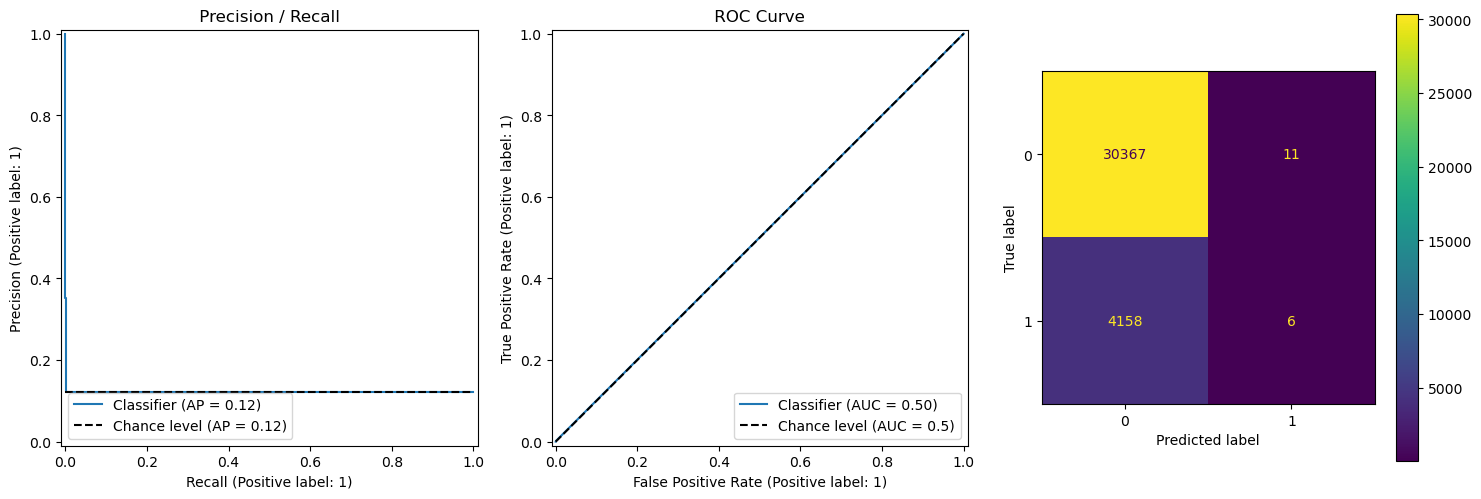

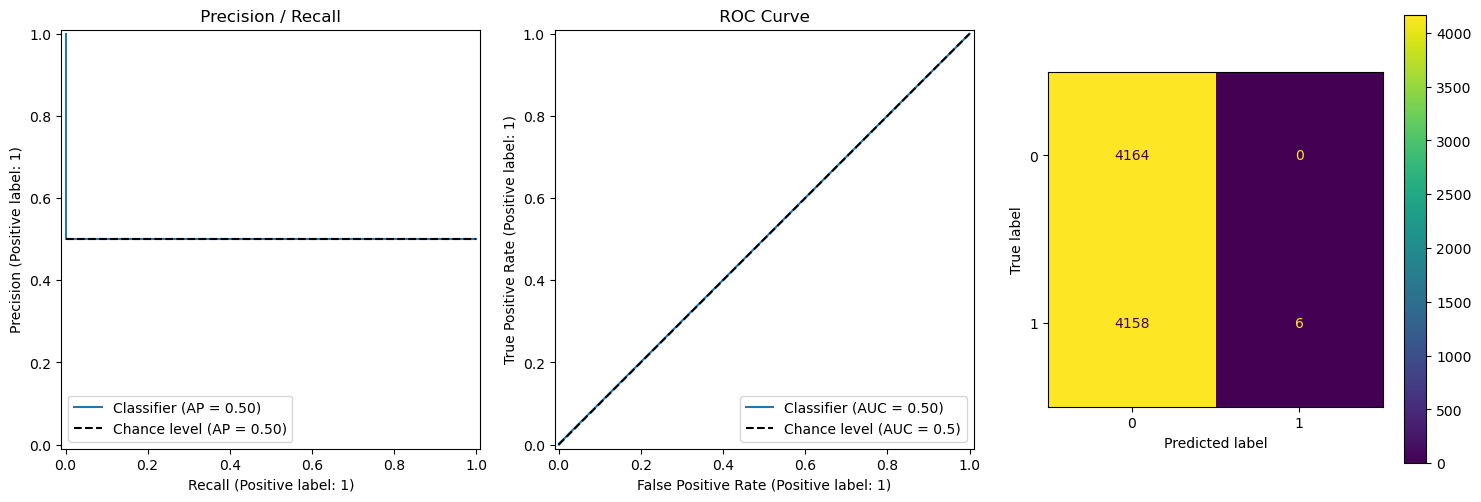

In [160]:
plots_from_predictions(test_y, y_pred)
plots_from_predictions(bal_test_y, bal_y_pred)

## Metrics - 1

In [303]:
FILENAME = 'KNN_estimators_1.pkl'

In [304]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


In [307]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [309]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,532      % 99.97 
 Label 1:      10      % 0.03 



In [311]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879567
 Precision: 0.70000     Recall: 0.00168     F1: 0.00335 
 True + labels: 4164.0  Predicted + labels: 10.0     Match: 30382 


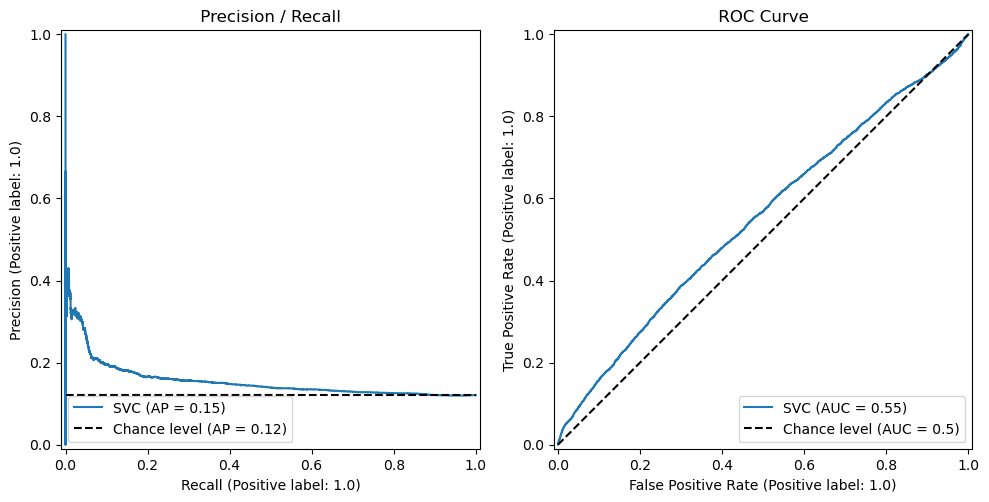

In [313]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

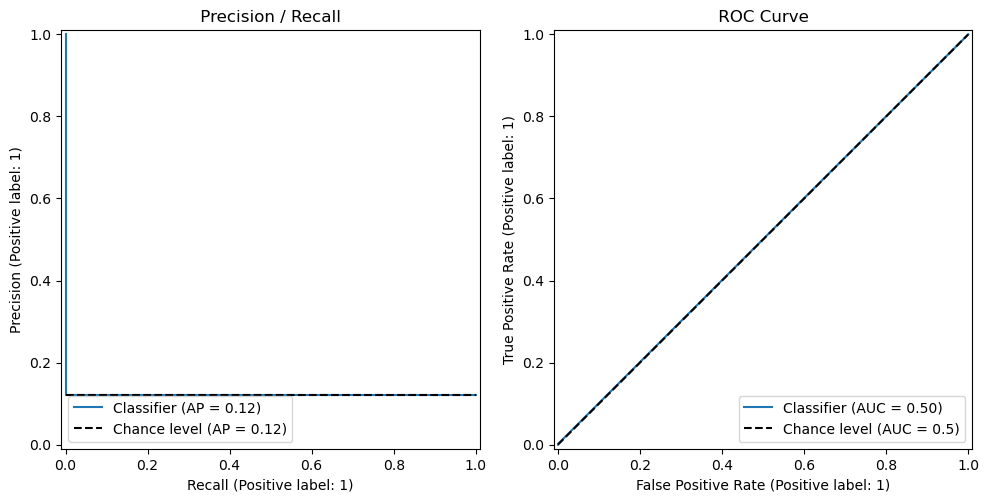

In [314]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

# XGBoost Model - Param search using Optuna 

  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/cellpainting/cj-datasets/optuna_database.db`

## setup Optuna

In [102]:
import sqlite3
import optuna
# from KevinsRoutines.utils.utils_optuna import disp_study_history, disp_trial_info
from KevinsRoutines.utils.utils_optuna import disp_trial_info
from utils.utils_cellpainting import disp_study_history

In [103]:
db_path = "../cj-datasets/optuna_database.db"
storage_url = "sqlite:///../cj-datasets/optuna_database.db"
# old_storage_url = "sqlite:///../cj-datasets/optuna_database_old.db"

In [128]:
## https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RetryFailedTrialCallback.html
#
from optuna.storages import RetryFailedTrialCallback
#
optuna_storage = optuna.storages.RDBStorage(
    url=storage_url, 
    heartbeat_interval=60,
    grace_period=120,
    failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
)

/tmp/ipykernel_3367810/1677463186.py:9: ExperimentalWarning: RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.
  failed_trial_callback=RetryFailedTrialCallback(max_retry=3),


In [129]:
with sqlite3.connect(db_path) as conn:
    conn.row_factory = sqlite3.Row
    results = conn.execute("SELECT * FROM studies ;").fetchall()
    db_studies = [dict(r) for r in results]
    db_studies
# study_name = db_studies[-2]['study_name'] 


[{'study_id': 6, 'study_name': 'classification-study-Apr24'},
 {'study_id': 7, 'study_name': 'classification-3SampleStudy-Apr24'},
 {'study_id': 10, 'study_name': 'cls-3_SampleStudy-Aug09'},
 {'study_id': 12, 'study_name': 'test_study_01'},
 {'study_id': 13, 'study_name': 'embd_cls_XGB_base_unbal'},
 {'study_id': 14, 'study_name': 'embd_cls_XGB_snnl_unbal'},
 {'study_id': 15, 'study_name': 'classification-study-Feb24'},
 {'study_id': 16, 'study_name': 'embd_cls_XGB_base_bal_1:1'},
 {'study_id': 17, 'study_name': 'embd_cls_XGB_snnl_bal_1:1'},
 {'study_id': 18, 'study_name': 'embd_cls_XGB_snnl_unbal_Aug13'}]

In [130]:
#     print(f" {study_name} will be kept")
# study_name = 'embd_cls_XGB_base_bal_1:1'
# study_name = 'embd_cls_XGB_snnl_unbal_Aug13'
 
study = optuna.create_study(storage=optuna_storage,
                            study_name=study_name,
                            directions=["maximize","minimize"], 
                            load_if_exists=True)
study.set_metric_names(["roc_auc", "logloss"])

[I 2024-08-20 01:53:57,358] Using an existing study with name 'embd_cls_XGB_snnl_unbal_Aug13' instead of creating a new one.
/tmp/ipykernel_3367810/2288727794.py:9: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(["roc_auc", "logloss"])


In [148]:
# study_name = 'test_study_01'
# study_name = "classification-study-1"
# study_name = "classification-study-Apr24"
# study_name = 'cls-3_SampleStudy-Aug09'
# disp_study_history(study, )
# study.best_trials[0].params

# study_name = 'embd_cls_XGB_base_unbal'
# study_name = 'embd_cls_XGB_snnl_unbal'
# study_name = 'embd_cls_XGB_snnl_unbal_Aug13'
# study_name = 'embd_cls_XGB_snnl_bal_1:1'
# study_name = 'embd_cls_XGB_base_bal_1:1'
# study_name = 'test_study_01'

# for study_name in ['embd_cls_XGB_base_bal_1:1','embd_cls_XGB_snnl_bal_1:1']:
for study_name in ['embd_cls_XGB_base_unbal','embd_cls_XGB_snnl_unbal', 'embd_cls_XGB_snnl_unbal_Aug13']:
    study  = optuna.load_study(study_name= study_name , storage=optuna_storage)
    disp_study_history(study, best_only = True )
    # disp_study_history(study )

study.best_trials[0].params


 embd_cls_XGB_base_unbal  study history

 Total trials in study: 90
 Best trials: [21, 41, 44, 63, 71]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 21   2024-08-09   18:01:05 - 18:02:10    1      0.60700        0.35187    
Trial #: 41   2024-08-09   19:46:13 - 19:47:43    1      0.60590        0.35024    
Trial #: 44   2024-08-09   19:50:16 - 19:51:08    1      0.58397        0.34572    
Trial #: 63   2024-08-09   20:59:32 - 21:00:24    1      0.59100        0.34950    
Trial #: 71   2024-08-09   21:08:42 - 21:09:34    1      0.56287        0.33219    
 *** end of trials *** 
 embd_cls_XGB_snnl_unbal  study history

 Total trials in study: 98
 Best trials: [42, 66, 71, 73, 82, 85]
                start     -   completion      status        validation metrics
 trial#         time      -

{'n_estimators': 350,
 'learning_rate': 0.18692815017557773,
 'min_split_loss': 0.5359224814088268,
 'max_depth': 11,
 'min_child_weight': 6.5403231044779435,
 'max_delta_step': 9.98831058720406,
 'subsample': 0.6231597751527712,
 'colsample_bylevel': 0.6920822143503388,
 'colsample_bynode': 0.6153168018995979,
 'lamba': 0.01719144961219317,
 'max_leaves': 4}

In [149]:
# study_name = 'embd_cls_XGB_base_bal_1:1'
# study  = optuna.load_study(study_name= study_name , storage=optuna_storage)
# disp_study_history(study, best_only = True)
disp_study_history(study)
# study.best_trials[0].params

 embd_cls_XGB_snnl_unbal_Aug13  study history

 Total trials in study: 65
 Best trials: [47, 49]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-08-13   16:59:45 - 17:01:31    1      0.57353        0.36029    
Trial #: 1    2024-08-13   17:01:31 - 17:05:23    1      0.59273        0.35562    
Trial #: 2    2024-08-13   17:05:24 - 17:08:35    1      0.56563        0.37863    
Trial #: 3    2024-08-13   17:08:35 - 17:09:51    1      0.53156        4.73040    
Trial #: 4    2024-08-13   17:09:51 - 17:12:46    1      0.55415        0.37822    
Trial #: 5    2024-08-13   17:12:46 - 17:14:01    1      0.48071        2.35045    
Trial #: 6    2024-08-13   17:14:02 - 17:19:59    1      0.57955        0.36009    
Trial #: 7    2024-08-13   17:20:00 - 17:21:20    1      0.52330        0.5

## Run studies

In [150]:
# X_DATA, Y_DATA, GRP_DATA = bal_train_X, bal_train_y, bal_grouping_xy
X_DATA, Y_DATA, GRP_DATA = train_X, train_y, grouping_xy
label_counts([("Test", Y_DATA)])

 Test
 -----
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 



In [134]:

# del iter_files

In [135]:
start = datetime.now()
sgkf = StratifiedGroupKFold(n_splits = 5 )
split_iterator = lambda: sgkf.split(X_DATA, Y_DATA, GRP_DATA)    
# 

In [136]:
# del objective
# objective = OptunaObjective(iter_files = split_iterator, folds = 5, X_Data=X_DATA, Y_Data= Y_DATA, Grp_Data = GRP_DATA, disp_params=True, save=True)
objective = OptunaObjective(iter_files = split_iterator, folds = 5, disp_params=True, save=True)

In [139]:

study.optimize(objective, n_trials=70, timeout=3600*7, gc_after_trial=True, show_progress_bar=True)

print(f"Total time:  {datetime.now() - start}")

  0%|          | 0/70 [00:00<?, ?it/s]

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 10


2024-08-20 02:05:47,877 - root - INFO: - CrossValidation split #0
2024-08-20 02:05:47,950 - root - INFO: - Running model on training set...
2024-08-20 02:05:58,619 - root - INFO: - Running model on validation data...
2024-08-20 02:05:58,663 - root - INFO: - Calculating metrics...
2024-08-20 02:05:58,709 - root - INFO: - CrossValidation split #1
2024-08-20 02:05:58,775 - root - INFO: - Running model on training set...
2024-08-20 02:06:07,384 - root - INFO: - Running model on validation data...
2024-08-20 02:06:07,416 - root - INFO: - Calculating metrics...
2024-08-20 02:06:07,451 - root - INFO: - CrossValidation split #2
2024-08-20 02:06:07,498 - root - INFO: - Running model on training set...
2024-08-20 02:06:17,555 - root - INFO: - Running model on validation data...
2024-08-20 02:06:17,601 - root - INFO: - Calculating metrics...
2024-08-20 02:06:17,644 - root - INFO: - CrossValidation split #3
2024-08-20 02:06:17,717 - root - INFO: - Running model on training set...
2024-08-20 02:06:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56516    0.56712    0.57050    0.57017    0.56957     0.56850 +/- 0.00205
 train_logloss       :   0.68996    0.68988    0.68984    0.68999    0.68993     0.68992 +/- 0.00006
 val_auc             :   0.56048    0.55834    0.55773    0.56750    0.56430     0.56167 +/- 0.00371
 val_logloss         :   0.68996    0.68988    0.68984    0.68999    0.68993     0.68992 +/- 0.00006
 roc_auc             :   0.54325    0.54215    0.54115    0.54826    0.54456     0.54387 +/- 0.00247
 logloss             :  16.46304   16.50273   16.53910   16.28208   16.41544    16.44048 +/- 0.08925

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 11


2024-08-20 02:06:50,277 - root - INFO: - CrossValidation split #0
2024-08-20 02:06:50,357 - root - INFO: - Running model on training set...
2024-08-20 02:07:04,835 - root - INFO: - Running model on validation data...
2024-08-20 02:07:04,895 - root - INFO: - Calculating metrics...
2024-08-20 02:07:04,934 - root - INFO: - CrossValidation split #1
2024-08-20 02:07:05,138 - root - INFO: - Running model on training set...
2024-08-20 02:07:17,801 - root - INFO: - Running model on validation data...
2024-08-20 02:07:17,860 - root - INFO: - Calculating metrics...
2024-08-20 02:07:17,903 - root - INFO: - CrossValidation split #2
2024-08-20 02:07:17,967 - root - INFO: - Running model on training set...
2024-08-20 02:07:31,209 - root - INFO: - Running model on validation data...
2024-08-20 02:07:31,268 - root - INFO: - Calculating metrics...
2024-08-20 02:07:31,309 - root - INFO: - CrossValidation split #3
2024-08-20 02:07:31,380 - root - INFO: - Running model on training set...
2024-08-20 02:07:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57972    0.58114    0.58247    0.58128    0.58208     0.58134 +/- 0.00095
 train_logloss       :   0.68505    0.68477    0.68437    0.68472    0.68447     0.68468 +/- 0.00024
 val_auc             :   0.57795    0.57451    0.56912    0.57425    0.57332     0.57383 +/- 0.00283
 val_logloss         :   0.68505    0.68477    0.68437    0.68472    0.68447     0.68468 +/- 0.00024
 roc_auc             :   0.55186    0.55124    0.54996    0.55135    0.55014     0.55091 +/- 0.00073
 logloss             :  16.15273   16.17539   16.22146   16.17054   16.21419    16.18686 +/- 0.02648

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 12


2024-08-20 02:08:08,321 - root - INFO: - CrossValidation split #0
2024-08-20 02:08:08,443 - root - INFO: - Running model on training set...
2024-08-20 02:08:23,072 - root - INFO: - Running model on validation data...
2024-08-20 02:08:23,126 - root - INFO: - Calculating metrics...
2024-08-20 02:08:23,164 - root - INFO: - CrossValidation split #1
2024-08-20 02:08:23,290 - root - INFO: - Running model on training set...
2024-08-20 02:08:39,137 - root - INFO: - Running model on validation data...
2024-08-20 02:08:39,195 - root - INFO: - Calculating metrics...
2024-08-20 02:08:39,234 - root - INFO: - CrossValidation split #2
2024-08-20 02:08:39,306 - root - INFO: - Running model on training set...
2024-08-20 02:08:54,817 - root - INFO: - Running model on validation data...
2024-08-20 02:08:54,875 - root - INFO: - Calculating metrics...
2024-08-20 02:08:54,914 - root - INFO: - CrossValidation split #3
2024-08-20 02:08:55,001 - root - INFO: - Running model on training set...
2024-08-20 02:09:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58714    0.58909    0.58947    0.58809    0.58927     0.58861 +/- 0.00088
 train_logloss       :   0.68338    0.68292    0.68266    0.68309    0.68293     0.68299 +/- 0.00024
 val_auc             :   0.58247    0.57935    0.57412    0.57945    0.57782     0.57864 +/- 0.00272
 val_logloss         :   0.68338    0.68292    0.68266    0.68309    0.68293     0.68299 +/- 0.00024
 roc_auc             :   0.55549    0.55582    0.55306    0.55538    0.55484     0.55492 +/- 0.00098
 logloss             :  16.02183   16.01051   16.10992   16.02506   16.04446    16.04236 +/- 0.03551

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 13


2024-08-20 02:09:36,822 - root - INFO: - CrossValidation split #0
2024-08-20 02:09:36,897 - root - INFO: - Running model on training set...
2024-08-20 02:09:52,551 - root - INFO: - Running model on validation data...
2024-08-20 02:09:52,618 - root - INFO: - Calculating metrics...
2024-08-20 02:09:52,658 - root - INFO: - CrossValidation split #1
2024-08-20 02:09:52,723 - root - INFO: - Running model on training set...
2024-08-20 02:10:07,308 - root - INFO: - Running model on validation data...
2024-08-20 02:10:07,375 - root - INFO: - Calculating metrics...
2024-08-20 02:10:07,416 - root - INFO: - CrossValidation split #2
2024-08-20 02:10:07,489 - root - INFO: - Running model on training set...
2024-08-20 02:10:22,931 - root - INFO: - Running model on validation data...
2024-08-20 02:10:22,981 - root - INFO: - Calculating metrics...
2024-08-20 02:10:23,021 - root - INFO: - CrossValidation split #3
2024-08-20 02:10:23,091 - root - INFO: - Running model on training set...
2024-08-20 02:10:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58642    0.58862    0.58819    0.58891    0.58883     0.58820 +/- 0.00092
 train_logloss       :   0.68334    0.68297    0.68271    0.68287    0.68296     0.68297 +/- 0.00021
 val_auc             :   0.58292    0.57821    0.57365    0.57962    0.57841     0.57856 +/- 0.00298
 val_logloss         :   0.68334    0.68297    0.68271    0.68287    0.68296     0.68297 +/- 0.00021
 roc_auc             :   0.55603    0.55575    0.55346    0.55565    0.55478     0.55513 +/- 0.00093
 logloss             :  16.00243   16.01294   16.09538   16.01536   16.04688    16.03460 +/- 0.03382

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 14


2024-08-20 02:11:05,785 - root - INFO: - CrossValidation split #0
2024-08-20 02:11:05,857 - root - INFO: - Running model on training set...
2024-08-20 02:11:16,603 - root - INFO: - Running model on validation data...
2024-08-20 02:11:16,665 - root - INFO: - Calculating metrics...
2024-08-20 02:11:16,706 - root - INFO: - CrossValidation split #1
2024-08-20 02:11:16,772 - root - INFO: - Running model on training set...
2024-08-20 02:11:28,822 - root - INFO: - Running model on validation data...
2024-08-20 02:11:28,895 - root - INFO: - Calculating metrics...
2024-08-20 02:11:28,937 - root - INFO: - CrossValidation split #2
2024-08-20 02:11:29,017 - root - INFO: - Running model on training set...
2024-08-20 02:11:41,030 - root - INFO: - Running model on validation data...
2024-08-20 02:11:41,078 - root - INFO: - Calculating metrics...
2024-08-20 02:11:41,118 - root - INFO: - CrossValidation split #3
2024-08-20 02:11:41,189 - root - INFO: - Running model on training set...
2024-08-20 02:11:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56528    0.56696    0.57086    0.57040    0.56936     0.56857 +/- 0.00213
 train_logloss       :   0.69107    0.69095    0.69088    0.69082    0.69086     0.69091 +/- 0.00009
 val_auc             :   0.55955    0.55626    0.55777    0.56630    0.56394     0.56077 +/- 0.00378
 val_logloss         :   0.69107    0.69095    0.69088    0.69082    0.69086     0.69091 +/- 0.00009
 roc_auc             :   0.54015    0.53839    0.54068    0.54872    0.54765     0.54312 +/- 0.00422
 logloss             :  16.57455   16.63852   16.55608   16.26511   16.30390    16.46763 +/- 0.15250

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 15


2024-08-20 02:12:16,939 - root - INFO: - CrossValidation split #0
2024-08-20 02:12:17,010 - root - INFO: - Running model on training set...
2024-08-20 02:12:30,380 - root - INFO: - Running model on validation data...
2024-08-20 02:12:30,421 - root - INFO: - Calculating metrics...
2024-08-20 02:12:30,461 - root - INFO: - CrossValidation split #1
2024-08-20 02:12:30,527 - root - INFO: - Running model on training set...
2024-08-20 02:12:44,881 - root - INFO: - Running model on validation data...
2024-08-20 02:12:44,921 - root - INFO: - Calculating metrics...
2024-08-20 02:12:44,960 - root - INFO: - CrossValidation split #2
2024-08-20 02:12:45,033 - root - INFO: - Running model on training set...
2024-08-20 02:12:57,935 - root - INFO: - Running model on validation data...
2024-08-20 02:12:57,988 - root - INFO: - Calculating metrics...
2024-08-20 02:12:58,029 - root - INFO: - CrossValidation split #3
2024-08-20 02:12:58,101 - root - INFO: - Running model on training set...
2024-08-20 02:13:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.59245    0.59367    0.59372    0.59263    0.59282     0.59306 +/- 0.00054
 train_logloss       :   0.68061    0.68024    0.67994    0.68027    0.68038     0.68029 +/- 0.00022
 val_auc             :   0.58766    0.58516    0.57933    0.58421    0.58175     0.58362 +/- 0.00286
 val_logloss         :   0.68061    0.68024    0.67994    0.68027    0.68038     0.68029 +/- 0.00022
 roc_auc             :   0.55905    0.55810    0.55521    0.56057    0.55741     0.55807 +/- 0.00178
 logloss             :  15.89334   15.92807   16.03233   15.83835   15.95232    15.92888 +/- 0.06436

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 16


2024-08-20 02:13:33,318 - root - INFO: - CrossValidation split #0
2024-08-20 02:13:33,387 - root - INFO: - Running model on training set...
2024-08-20 02:13:38,777 - root - INFO: - Running model on validation data...
2024-08-20 02:13:38,807 - root - INFO: - Calculating metrics...
2024-08-20 02:13:38,847 - root - INFO: - CrossValidation split #1
2024-08-20 02:13:38,883 - root - INFO: - Running model on training set...
2024-08-20 02:13:45,564 - root - INFO: - Running model on validation data...
2024-08-20 02:13:45,593 - root - INFO: - Calculating metrics...
2024-08-20 02:13:45,631 - root - INFO: - CrossValidation split #2
2024-08-20 02:13:45,702 - root - INFO: - Running model on training set...
2024-08-20 02:13:52,276 - root - INFO: - Running model on validation data...
2024-08-20 02:13:52,304 - root - INFO: - Calculating metrics...
2024-08-20 02:13:52,341 - root - INFO: - CrossValidation split #3
2024-08-20 02:13:52,383 - root - INFO: - Running model on training set...
2024-08-20 02:13:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58591    0.58764    0.58730    0.58685    0.58685     0.58691 +/- 0.00058
 train_logloss       :   0.68291    0.68268    0.68244    0.68268    0.68265     0.68267 +/- 0.00015
 val_auc             :   0.58287    0.57915    0.57303    0.57771    0.57680     0.57791 +/- 0.00320
 val_logloss         :   0.68291    0.68268    0.68244    0.68268    0.68265     0.68267 +/- 0.00015
 roc_auc             :   0.55502    0.55547    0.55029    0.55472    0.55391     0.55388 +/- 0.00187
 logloss             :  16.03880   16.02263   16.20934   16.04931   16.07840    16.07970 +/- 0.06732

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 17


2024-08-20 02:14:17,863 - root - INFO: - CrossValidation split #0
2024-08-20 02:14:17,937 - root - INFO: - Running model on training set...
2024-08-20 02:14:27,331 - root - INFO: - Running model on validation data...
2024-08-20 02:14:27,370 - root - INFO: - Calculating metrics...
2024-08-20 02:14:27,411 - root - INFO: - CrossValidation split #1
2024-08-20 02:14:27,476 - root - INFO: - Running model on training set...
2024-08-20 02:14:38,222 - root - INFO: - Running model on validation data...
2024-08-20 02:14:38,261 - root - INFO: - Calculating metrics...
2024-08-20 02:14:38,301 - root - INFO: - CrossValidation split #2
2024-08-20 02:14:38,373 - root - INFO: - Running model on training set...
2024-08-20 02:14:48,548 - root - INFO: - Running model on validation data...
2024-08-20 02:14:48,588 - root - INFO: - Calculating metrics...
2024-08-20 02:14:48,630 - root - INFO: - CrossValidation split #3
2024-08-20 02:14:48,702 - root - INFO: - Running model on training set...
2024-08-20 02:14:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.55961    0.56087    0.56510    0.56902    0.56757     0.56444 +/- 0.00367
 train_logloss       :   0.69263    0.69262    0.69262    0.69266    0.69264     0.69263 +/- 0.00001
 val_auc             :   0.55400    0.55034    0.55298    0.56726    0.56375     0.55767 +/- 0.00661
 val_logloss         :   0.69263    0.69262    0.69262    0.69266    0.69264     0.69263 +/- 0.00001
 roc_auc             :   0.53935    0.53603    0.53597    0.54806    0.54590     0.54106 +/- 0.00503
 logloss             :  16.60364   16.72338   16.72581   16.28936   16.36695    16.54183 +/- 0.18164

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 18


2024-08-20 02:15:21,641 - root - INFO: - CrossValidation split #0
2024-08-20 02:15:21,711 - root - INFO: - Running model on training set...
2024-08-20 02:15:32,199 - root - INFO: - Running model on validation data...
2024-08-20 02:15:32,237 - root - INFO: - Calculating metrics...
2024-08-20 02:15:32,277 - root - INFO: - CrossValidation split #1
2024-08-20 02:15:32,342 - root - INFO: - Running model on training set...
2024-08-20 02:15:47,596 - root - INFO: - Running model on validation data...
2024-08-20 02:15:47,637 - root - INFO: - Calculating metrics...
2024-08-20 02:15:47,674 - root - INFO: - CrossValidation split #2
2024-08-20 02:15:47,746 - root - INFO: - Running model on training set...
2024-08-20 02:15:54,474 - root - INFO: - Running model on validation data...
2024-08-20 02:15:54,500 - root - INFO: - Calculating metrics...
2024-08-20 02:15:54,536 - root - INFO: - CrossValidation split #3
2024-08-20 02:15:54,580 - root - INFO: - Running model on training set...
2024-08-20 02:16:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.59627    0.59938    0.59487    0.59587    0.59587     0.59645 +/- 0.00154
 train_logloss       :   0.67990    0.67905    0.67992    0.67971    0.67987     0.67969 +/- 0.00033
 val_auc             :   0.58915    0.58433    0.57662    0.58490    0.58147     0.58330 +/- 0.00414
 val_logloss         :   0.67990    0.67905    0.67992    0.67971    0.67987     0.67969 +/- 0.00033
 roc_auc             :   0.56289    0.55878    0.55535    0.56003    0.55868     0.55914 +/- 0.00243
 logloss             :  15.75516   15.90382   16.02748   15.85775   15.90625    15.89009 +/- 0.08784

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 19


2024-08-20 02:16:21,873 - root - INFO: - CrossValidation split #0
2024-08-20 02:16:21,944 - root - INFO: - Running model on training set...
2024-08-20 02:16:32,458 - root - INFO: - Running model on validation data...
2024-08-20 02:16:32,495 - root - INFO: - Calculating metrics...
2024-08-20 02:16:32,536 - root - INFO: - CrossValidation split #1
2024-08-20 02:16:32,570 - root - INFO: - Running model on training set...
2024-08-20 02:16:43,869 - root - INFO: - Running model on validation data...
2024-08-20 02:16:43,909 - root - INFO: - Calculating metrics...
2024-08-20 02:16:43,949 - root - INFO: - CrossValidation split #2
2024-08-20 02:16:44,021 - root - INFO: - Running model on training set...
2024-08-20 02:16:50,366 - root - INFO: - Running model on validation data...
2024-08-20 02:16:50,395 - root - INFO: - Calculating metrics...
2024-08-20 02:16:50,430 - root - INFO: - CrossValidation split #3
2024-08-20 02:16:50,476 - root - INFO: - Running model on training set...
2024-08-20 02:16:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.59576    0.59942    0.59892    0.59918    0.59897     0.59845 +/- 0.00136
 train_logloss       :   0.67984    0.67884    0.67872    0.67895    0.67899     0.67907 +/- 0.00040
 val_auc             :   0.58864    0.58438    0.57919    0.58629    0.58083     0.58387 +/- 0.00346
 val_logloss         :   0.67984    0.67884    0.67872    0.67895    0.67899     0.67907 +/- 0.00040
 roc_auc             :   0.56107    0.55831    0.55467    0.56191    0.56097     0.55939 +/- 0.00265
 logloss             :  15.82061   15.92080   16.05173   15.78986   15.82381    15.88136 +/- 0.09587

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 20


2024-08-20 02:17:19,789 - root - INFO: - CrossValidation split #0
2024-08-20 02:17:19,860 - root - INFO: - Running model on training set...
2024-08-20 02:17:26,705 - root - INFO: - Running model on validation data...
2024-08-20 02:17:26,769 - root - INFO: - Calculating metrics...
2024-08-20 02:17:26,809 - root - INFO: - CrossValidation split #1
2024-08-20 02:17:26,887 - root - INFO: - Running model on training set...
2024-08-20 02:17:34,365 - root - INFO: - Running model on validation data...
2024-08-20 02:17:34,418 - root - INFO: - Calculating metrics...
2024-08-20 02:17:34,458 - root - INFO: - CrossValidation split #2
2024-08-20 02:17:34,530 - root - INFO: - Running model on training set...
2024-08-20 02:17:42,627 - root - INFO: - Running model on validation data...
2024-08-20 02:17:42,672 - root - INFO: - Calculating metrics...
2024-08-20 02:17:42,707 - root - INFO: - CrossValidation split #3
2024-08-20 02:17:42,749 - root - INFO: - Running model on training set...
2024-08-20 02:17:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57684    0.57849    0.58015    0.57854    0.57773     0.57835 +/- 0.00109
 train_logloss       :   0.68903    0.68889    0.68876    0.68890    0.68885     0.68889 +/- 0.00009
 val_auc             :   0.57113    0.56613    0.56400    0.57251    0.56829     0.56841 +/- 0.00313
 val_logloss         :   0.68903    0.68889    0.68876    0.68890    0.68885     0.68889 +/- 0.00009
 roc_auc             :   0.54930    0.54559    0.54351    0.55276    0.54738     0.54771 +/- 0.00317
 logloss             :  16.24486   16.37907   16.45424   16.11962   16.31360    16.30228 +/- 0.11470

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 21


2024-08-20 02:18:09,988 - root - INFO: - CrossValidation split #0
2024-08-20 02:18:10,060 - root - INFO: - Running model on training set...
2024-08-20 02:18:11,678 - root - INFO: - Running model on validation data...
2024-08-20 02:18:11,696 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:18:11,729 - root - INFO: - CrossValidation split #1
2024-08-20 02:18:11,770 - root - INFO: - Running model on training set...
2024-08-20 02:18:13,522 - root - INFO: - Running model on validation data...
2024-08-20 02:18:13,540 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.01819   18.01819   18.01819   18.01819    18.01892 +/- 0.00145

2024-08-20 02:18:31,539 - root - INFO: - CrossValidation split #0
2024-08-20 02:18:31,611 - root - INFO: - Running model on training set...
2024-08-20 02:18:42,549 - root - INFO: - Running model on validation data...
2024-08-20 02:18:42,609 - root - INFO: - Calculating metrics...
2024-08-20 02:18:42,649 - root - INFO: - CrossValidation split #1
2024-08-20 02:18:42,714 - root - INFO: - Running model on training set...
2024-08-20 02:18:54,679 - root - INFO: - Running model on validation data...
2024-08-20 02:18:54,755 - root - INFO: - Calculating metrics...
2024-08-20 02:18:54,793 - root - INFO: - CrossValidation split #2
2024-08-20 02:18:54,866 - root - INFO: - Running model on training set...
2024-08-20 02:19:06,757 - root - INFO: - Running model on validation data...
2024-08-20 02:19:06,818 - root - INFO: - Calculating metrics...
2024-08-20 02:19:06,861 - root - INFO: - CrossValidation split #3
2024-08-20 02:19:06,913 - root - INFO: - Running model on training set...
2024-08-20 02:19:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.61940    0.62247    0.62378    0.62140    0.62239     0.62189 +/- 0.00146
 train_logloss       :   0.67304    0.67203    0.67164    0.67233    0.67186     0.67218 +/- 0.00049
 val_auc             :   0.59734    0.59200    0.59010    0.59333    0.59385     0.59332 +/- 0.00239
 val_logloss         :   0.67304    0.67203    0.67164    0.67233    0.67186     0.67218 +/- 0.00049
 roc_auc             :   0.57008    0.56456    0.56396    0.56608    0.56702     0.56634 +/- 0.00216
 logloss             :  15.49576   15.69530   15.71712   15.63953   15.60558    15.63066 +/- 0.07818

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 23


2024-08-20 02:19:41,001 - root - INFO: - CrossValidation split #0
2024-08-20 02:19:41,075 - root - INFO: - Running model on training set...
2024-08-20 02:20:03,026 - root - INFO: - Running model on validation data...
2024-08-20 02:20:03,298 - root - INFO: - Calculating metrics...
2024-08-20 02:20:03,334 - root - INFO: - CrossValidation split #1
2024-08-20 02:20:03,391 - root - INFO: - Running model on training set...
2024-08-20 02:20:25,968 - root - INFO: - Running model on validation data...
2024-08-20 02:20:26,247 - root - INFO: - Calculating metrics...
2024-08-20 02:20:26,293 - root - INFO: - CrossValidation split #2
2024-08-20 02:20:26,492 - root - INFO: - Running model on training set...
2024-08-20 02:20:48,738 - root - INFO: - Running model on validation data...
2024-08-20 02:20:49,003 - root - INFO: - Calculating metrics...
2024-08-20 02:20:49,039 - root - INFO: - CrossValidation split #3
2024-08-20 02:20:49,110 - root - INFO: - Running model on training set...
2024-08-20 02:21:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.64198    0.64198    0.64536    0.64371    0.64477     0.64356 +/- 0.00139
 train_logloss       :   0.69314    0.69314    0.69314    0.69314    0.69314     0.69314 +/- 0.00000
 val_auc             :   0.59347    0.58435    0.58493    0.59082    0.58866     0.58845 +/- 0.00347
 val_logloss         :   0.69314    0.69314    0.69314    0.69314    0.69314     0.69314 +/- 0.00000
 roc_auc             :   0.56450    0.52952    0.52965    0.50047    0.50047     0.52492 +/- 0.02369
 logloss             :  15.69698   16.96101   16.95616   18.00849   18.00849    17.12622 +/- 0.85507

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 24


2024-08-20 02:21:45,722 - root - INFO: - CrossValidation split #0
2024-08-20 02:21:45,797 - root - INFO: - Running model on training set...
2024-08-20 02:22:03,147 - root - INFO: - Running model on validation data...
2024-08-20 02:22:03,357 - root - INFO: - Calculating metrics...
2024-08-20 02:22:03,399 - root - INFO: - CrossValidation split #1
2024-08-20 02:22:03,595 - root - INFO: - Running model on training set...
2024-08-20 02:22:21,425 - root - INFO: - Running model on validation data...
2024-08-20 02:22:21,651 - root - INFO: - Calculating metrics...
2024-08-20 02:22:21,691 - root - INFO: - CrossValidation split #2
2024-08-20 02:22:21,770 - root - INFO: - Running model on training set...
2024-08-20 02:22:39,102 - root - INFO: - Running model on validation data...
2024-08-20 02:22:39,319 - root - INFO: - Calculating metrics...
2024-08-20 02:22:39,357 - root - INFO: - CrossValidation split #3
2024-08-20 02:22:39,457 - root - INFO: - Running model on training set...
2024-08-20 02:22:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.61410    0.61680    0.61851    0.61559    0.61798     0.61660 +/- 0.00160
 train_logloss       :   0.69292    0.69290    0.69291    0.69291    0.69291     0.69291 +/- 0.00001
 val_auc             :   0.58817    0.58214    0.58146    0.58673    0.58397     0.58449 +/- 0.00259
 val_logloss         :   0.69292    0.69290    0.69291    0.69291    0.69291     0.69291 +/- 0.00001
 roc_auc             :   0.56275    0.55831    0.55596    0.56137    0.56103     0.55989 +/- 0.00243
 logloss             :  15.76001   15.92080   16.00566   15.80926   15.82138    15.86342 +/- 0.08823

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 25


2024-08-20 02:23:26,582 - root - INFO: - CrossValidation split #0
2024-08-20 02:23:26,655 - root - INFO: - Running model on training set...
2024-08-20 02:23:28,059 - root - INFO: - Running model on validation data...
2024-08-20 02:23:28,076 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:23:28,107 - root - INFO: - CrossValidation split #1
2024-08-20 02:23:28,166 - root - INFO: - Running model on training set...
2024-08-20 02:23:29,597 - root - INFO: - Running model on validation data...
2024-08-20 02:23:29,614 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.02546   18.02546   18.02546   18.02546    18.02474 +/- 0.00145

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 26


2024-08-20 02:23:45,021 - root - INFO: - CrossValidation split #0
2024-08-20 02:23:45,095 - root - INFO: - Running model on training set...
2024-08-20 02:24:04,229 - root - INFO: - Running model on validation data...
2024-08-20 02:24:04,437 - root - INFO: - Calculating metrics...
2024-08-20 02:24:04,473 - root - INFO: - CrossValidation split #1
2024-08-20 02:24:04,537 - root - INFO: - Running model on training set...
2024-08-20 02:24:23,575 - root - INFO: - Running model on validation data...
2024-08-20 02:24:23,792 - root - INFO: - Calculating metrics...
2024-08-20 02:24:23,832 - root - INFO: - CrossValidation split #2
2024-08-20 02:24:23,904 - root - INFO: - Running model on training set...
2024-08-20 02:24:43,170 - root - INFO: - Running model on validation data...
2024-08-20 02:24:43,373 - root - INFO: - Calculating metrics...
2024-08-20 02:24:43,410 - root - INFO: - CrossValidation split #3
2024-08-20 02:24:43,491 - root - INFO: - Running model on training set...
2024-08-20 02:25:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.73535    0.73225    0.73594    0.72918    0.73377     0.73330 +/- 0.00243
 train_logloss       :   0.68261    0.68247    0.68244    0.68281    0.68256     0.68258 +/- 0.00013
 val_auc             :   0.60061    0.59194    0.59045    0.59802    0.59673     0.59555 +/- 0.00380
 val_logloss         :   0.68261    0.68247    0.68244    0.68281    0.68256     0.68258 +/- 0.00013
 roc_auc             :   0.57076    0.56221    0.56154    0.57052    0.56688     0.56638 +/- 0.00393
 logloss             :  15.47152   15.78016   15.80441   15.47949   15.61043    15.62920 +/- 0.14221

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 27


2024-08-20 02:25:33,026 - root - INFO: - CrossValidation split #0
2024-08-20 02:25:33,101 - root - INFO: - Running model on training set...
2024-08-20 02:25:34,491 - root - INFO: - Running model on validation data...
2024-08-20 02:25:34,509 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:25:34,540 - root - INFO: - CrossValidation split #1
2024-08-20 02:25:34,576 - root - INFO: - Running model on training set...
2024-08-20 02:25:35,939 - root - INFO: - Running model on validation data...
2024-08-20 02:25:35,953 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.02546   18.02546   18.01819   18.01819    18.02183 +/- 0.00325

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 28


2024-08-20 02:25:52,259 - root - INFO: - CrossValidation split #0
2024-08-20 02:25:52,330 - root - INFO: - Running model on training set...
2024-08-20 02:25:58,044 - root - INFO: - Running model on validation data...
2024-08-20 02:25:58,071 - root - INFO: - Calculating metrics...
2024-08-20 02:25:58,108 - root - INFO: - CrossValidation split #1
2024-08-20 02:25:58,167 - root - INFO: - Running model on training set...
2024-08-20 02:26:04,002 - root - INFO: - Running model on validation data...
2024-08-20 02:26:04,043 - root - INFO: - Calculating metrics...
2024-08-20 02:26:04,083 - root - INFO: - CrossValidation split #2
2024-08-20 02:26:04,156 - root - INFO: - Running model on training set...
2024-08-20 02:26:09,934 - root - INFO: - Running model on validation data...
2024-08-20 02:26:09,961 - root - INFO: - Calculating metrics...
2024-08-20 02:26:09,996 - root - INFO: - CrossValidation split #3
2024-08-20 02:26:10,038 - root - INFO: - Running model on training set...
2024-08-20 02:26:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.55188    0.55449    0.55605    0.56414    0.56037     0.55739 +/- 0.00436
 train_logloss       :   0.69259    0.69257    0.69258    0.69263    0.69262     0.69260 +/- 0.00002
 val_auc             :   0.54418    0.54085    0.54216    0.56343    0.55660     0.54944 +/- 0.00896
 val_logloss         :   0.69259    0.69257    0.69258    0.69263    0.69262     0.69260 +/- 0.00002
 roc_auc             :   0.53067    0.52621    0.52151    0.54570    0.54509     0.53384 +/- 0.00988
 logloss             :  16.91637   17.07739   17.24712   16.37422   16.39604    16.80223 +/- 0.35633

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 29


2024-08-20 02:26:32,793 - root - INFO: - CrossValidation split #0
2024-08-20 02:26:32,866 - root - INFO: - Running model on training set...
2024-08-20 02:27:32,296 - root - INFO: - Running model on validation data...
2024-08-20 02:27:32,728 - root - INFO: - Calculating metrics...
2024-08-20 02:27:32,765 - root - INFO: - CrossValidation split #1
2024-08-20 02:27:32,832 - root - INFO: - Running model on training set...
2024-08-20 02:28:34,619 - root - INFO: - Running model on validation data...
2024-08-20 02:28:35,063 - root - INFO: - Calculating metrics...
2024-08-20 02:28:35,102 - root - INFO: - CrossValidation split #2
2024-08-20 02:28:35,180 - root - INFO: - Running model on training set...
2024-08-20 02:29:37,433 - root - INFO: - Running model on validation data...
2024-08-20 02:29:37,871 - root - INFO: - Calculating metrics...
2024-08-20 02:29:37,909 - root - INFO: - CrossValidation split #3
2024-08-20 02:29:37,978 - root - INFO: - Running model on training set...
2024-08-20 02:30:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.86402    0.85884    0.86073    0.85289    0.85795     0.85888 +/- 0.00365
 train_logloss       :   0.69214    0.69211    0.69210    0.69216    0.69212     0.69213 +/- 0.00002
 val_auc             :   0.59895    0.59087    0.58636    0.59657    0.59245     0.59304 +/- 0.00441
 val_logloss         :   0.69214    0.69211    0.69210    0.69216    0.69212     0.69213 +/- 0.00002
 roc_auc             :   0.56928    0.56214    0.55777    0.56729    0.56292     0.56388 +/- 0.00405
 logloss             :  15.52486   15.78259   15.94019   15.59588   15.75349    15.71940 +/- 0.14629

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 30


2024-08-20 02:31:50,671 - root - INFO: - CrossValidation split #0
2024-08-20 02:31:50,744 - root - INFO: - Running model on training set...
2024-08-20 02:31:52,174 - root - INFO: - Running model on validation data...
2024-08-20 02:31:52,192 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:31:52,224 - root - INFO: - CrossValidation split #1
2024-08-20 02:31:52,312 - root - INFO: - Running model on training set...
2024-08-20 02:31:53,703 - root - INFO: - Running model on validation data...
2024-08-20 02:31:53,720 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.02546   18.02546   18.01819   18.01819    18.02183 +/- 0.00325

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 31


2024-08-20 02:32:10,450 - root - INFO: - CrossValidation split #0
2024-08-20 02:32:10,480 - root - INFO: - Running model on training set...
2024-08-20 02:33:02,421 - root - INFO: - Running model on validation data...
2024-08-20 02:33:02,863 - root - INFO: - Calculating metrics...
2024-08-20 02:33:02,899 - root - INFO: - CrossValidation split #1
2024-08-20 02:33:02,964 - root - INFO: - Running model on training set...
2024-08-20 02:33:55,025 - root - INFO: - Running model on validation data...
2024-08-20 02:33:55,480 - root - INFO: - Calculating metrics...
2024-08-20 02:33:55,523 - root - INFO: - CrossValidation split #2
2024-08-20 02:33:55,595 - root - INFO: - Running model on training set...
2024-08-20 02:34:48,068 - root - INFO: - Running model on validation data...
2024-08-20 02:34:48,501 - root - INFO: - Calculating metrics...
2024-08-20 02:34:48,537 - root - INFO: - CrossValidation split #3
2024-08-20 02:34:48,636 - root - INFO: - Running model on training set...
2024-08-20 02:35:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.82789    0.82319    0.82215    0.82008    0.82669     0.82400 +/- 0.00289
 train_logloss       :   0.69211    0.69209    0.69208    0.69213    0.69209     0.69210 +/- 0.00002
 val_auc             :   0.59895    0.59176    0.58609    0.59492    0.59270     0.59288 +/- 0.00420
 val_logloss         :   0.69211    0.69209    0.69208    0.69213    0.69209     0.69210 +/- 0.00002
 roc_auc             :   0.56827    0.56040    0.55663    0.56413    0.56467     0.56282 +/- 0.00398
 logloss             :  15.56122   15.84563   15.98141   15.70984   15.69045    15.75771 +/- 0.14366

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 32


2024-08-20 02:36:43,059 - root - INFO: - CrossValidation split #0
2024-08-20 02:36:43,133 - root - INFO: - Running model on training set...
2024-08-20 02:36:53,146 - root - INFO: - Running model on validation data...
2024-08-20 02:36:53,274 - root - INFO: - Calculating metrics...
2024-08-20 02:36:53,321 - root - INFO: - CrossValidation split #1
2024-08-20 02:36:53,368 - root - INFO: - Running model on training set...
2024-08-20 02:37:03,575 - root - INFO: - Running model on validation data...
2024-08-20 02:37:03,710 - root - INFO: - Calculating metrics...
2024-08-20 02:37:03,759 - root - INFO: - CrossValidation split #2
2024-08-20 02:37:03,829 - root - INFO: - Running model on training set...
2024-08-20 02:37:14,004 - root - INFO: - Running model on validation data...
2024-08-20 02:37:14,130 - root - INFO: - Calculating metrics...
2024-08-20 02:37:14,165 - root - INFO: - CrossValidation split #3
2024-08-20 02:37:14,206 - root - INFO: - Running model on training set...
2024-08-20 02:37:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.60485    0.60676    0.60742    0.60456    0.60861     0.60644 +/- 0.00154
 train_logloss       :   0.69312    0.69312    0.69312    0.69312    0.69312     0.69312 +/- 0.00000
 val_auc             :   0.58579    0.57535    0.57688    0.58202    0.58167     0.58034 +/- 0.00377
 val_logloss         :   0.69312    0.69312    0.69312    0.69312    0.69312     0.69312 +/- 0.00000
 roc_auc             :   0.56302    0.55195    0.55383    0.55172    0.54950     0.55400 +/- 0.00471
 logloss             :  15.75031   16.15115   16.08325   16.15842   16.23844    16.07631 +/- 0.17027

2024-08-20 02:37:45,782 - root - INFO: - CrossValidation split #0
2024-08-20 02:37:45,865 - root - INFO: - Running model on training set...
2024-08-20 02:37:47,359 - root - INFO: - Running model on validation data...
2024-08-20 02:37:47,378 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:37:47,413 - root - INFO: - CrossValidation split #1
2024-08-20 02:37:47,466 - root - INFO: - Running model on training set...
2024-08-20 02:37:49,770 - root - INFO: - Running model on validation data...
2024-08-20 02:37:49,789 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.01819   18.01819   18.01819   18.01819    18.01892 +/- 0.00145

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 34


2024-08-20 02:38:09,028 - root - INFO: - CrossValidation split #0
2024-08-20 02:38:09,101 - root - INFO: - Running model on training set...
2024-08-20 02:38:27,016 - root - INFO: - Running model on validation data...
2024-08-20 02:38:27,237 - root - INFO: - Calculating metrics...
2024-08-20 02:38:27,274 - root - INFO: - CrossValidation split #1
2024-08-20 02:38:27,333 - root - INFO: - Running model on training set...
2024-08-20 02:38:45,366 - root - INFO: - Running model on validation data...
2024-08-20 02:38:45,580 - root - INFO: - Calculating metrics...
2024-08-20 02:38:45,617 - root - INFO: - CrossValidation split #2
2024-08-20 02:38:45,689 - root - INFO: - Running model on training set...
2024-08-20 02:39:03,145 - root - INFO: - Running model on validation data...
2024-08-20 02:39:03,376 - root - INFO: - Calculating metrics...
2024-08-20 02:39:03,414 - root - INFO: - CrossValidation split #3
2024-08-20 02:39:03,516 - root - INFO: - Running model on training set...
2024-08-20 02:39:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.69537    0.69896    0.70015    0.69718    0.69457     0.69725 +/- 0.00210
 train_logloss       :   0.65059    0.64919    0.64884    0.64986    0.65026     0.64975 +/- 0.00065
 val_auc             :   0.60773    0.60138    0.59952    0.60241    0.60397     0.60300 +/- 0.00277
 val_logloss         :   0.65059    0.64919    0.64884    0.64986    0.65026     0.64975 +/- 0.00065
 roc_auc             :   0.57614    0.56967    0.56833    0.57153    0.57563     0.57226 +/- 0.00313
 logloss             :  15.27758   15.51102   15.55951   15.44312   15.29521    15.41729 +/- 0.11322

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 35


2024-08-20 02:39:50,187 - root - INFO: - CrossValidation split #0
2024-08-20 02:39:50,264 - root - INFO: - Running model on training set...
2024-08-20 02:40:00,086 - root - INFO: - Running model on validation data...
2024-08-20 02:40:00,126 - root - INFO: - Calculating metrics...
2024-08-20 02:40:00,170 - root - INFO: - CrossValidation split #1
2024-08-20 02:40:00,237 - root - INFO: - Running model on training set...
2024-08-20 02:40:09,781 - root - INFO: - Running model on validation data...
2024-08-20 02:40:09,828 - root - INFO: - Calculating metrics...
2024-08-20 02:40:09,876 - root - INFO: - CrossValidation split #2
2024-08-20 02:40:09,949 - root - INFO: - Running model on training set...
2024-08-20 02:40:19,445 - root - INFO: - Running model on validation data...
2024-08-20 02:40:19,486 - root - INFO: - Calculating metrics...
2024-08-20 02:40:19,528 - root - INFO: - CrossValidation split #3
2024-08-20 02:40:19,602 - root - INFO: - Running model on training set...
2024-08-20 02:40:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57006    0.57199    0.57434    0.57349    0.57323     0.57262 +/- 0.00149
 train_logloss       :   0.68837    0.68822    0.68813    0.68829    0.68823     0.68825 +/- 0.00008
 val_auc             :   0.56804    0.56464    0.56254    0.56943    0.56698     0.56633 +/- 0.00246
 val_logloss         :   0.68837    0.68822    0.68813    0.68829    0.68823     0.68825 +/- 0.00008
 roc_auc             :   0.55098    0.54619    0.54256    0.55014    0.54893     0.54776 +/- 0.00306
 logloss             :  16.18425   16.35725   16.48818   16.21419   16.25783    16.30034 +/- 0.11066

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 36


2024-08-20 02:40:49,609 - root - INFO: - CrossValidation split #0
2024-08-20 02:40:49,683 - root - INFO: - Running model on training set...
2024-08-20 02:41:01,561 - root - INFO: - Running model on validation data...
2024-08-20 02:41:01,631 - root - INFO: - Calculating metrics...
2024-08-20 02:41:01,670 - root - INFO: - CrossValidation split #1
2024-08-20 02:41:01,763 - root - INFO: - Running model on training set...
2024-08-20 02:41:13,447 - root - INFO: - Running model on validation data...
2024-08-20 02:41:13,515 - root - INFO: - Calculating metrics...
2024-08-20 02:41:13,554 - root - INFO: - CrossValidation split #2
2024-08-20 02:41:13,625 - root - INFO: - Running model on training set...
2024-08-20 02:41:25,414 - root - INFO: - Running model on validation data...
2024-08-20 02:41:25,487 - root - INFO: - Calculating metrics...
2024-08-20 02:41:25,526 - root - INFO: - CrossValidation split #3
2024-08-20 02:41:25,601 - root - INFO: - Running model on training set...
2024-08-20 02:41:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57808    0.57853    0.58145    0.57924    0.57986     0.57943 +/- 0.00118
 train_logloss       :   0.69226    0.69224    0.69226    0.69225    0.69225     0.69225 +/- 0.00001
 val_auc             :   0.57074    0.56651    0.56554    0.57157    0.57028     0.56893 +/- 0.00243
 val_logloss         :   0.69226    0.69224    0.69226    0.69225    0.69225     0.69225 +/- 0.00001
 roc_auc             :   0.55112    0.54438    0.54391    0.55228    0.55027     0.54839 +/- 0.00353
 logloss             :  16.17940   16.42272   16.43969   16.13660   16.20934    16.27755 +/- 0.12768

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 37


2024-08-20 02:42:00,208 - root - INFO: - CrossValidation split #0
2024-08-20 02:42:00,280 - root - INFO: - Running model on training set...
2024-08-20 02:42:07,864 - root - INFO: - Running model on validation data...
2024-08-20 02:42:07,905 - root - INFO: - Calculating metrics...
2024-08-20 02:42:07,943 - root - INFO: - CrossValidation split #1
2024-08-20 02:42:08,007 - root - INFO: - Running model on training set...
2024-08-20 02:42:15,504 - root - INFO: - Running model on validation data...
2024-08-20 02:42:15,547 - root - INFO: - Calculating metrics...
2024-08-20 02:42:15,584 - root - INFO: - CrossValidation split #2
2024-08-20 02:42:15,628 - root - INFO: - Running model on training set...
2024-08-20 02:42:24,477 - root - INFO: - Running model on validation data...
2024-08-20 02:42:24,517 - root - INFO: - Calculating metrics...
2024-08-20 02:42:24,555 - root - INFO: - CrossValidation split #3
2024-08-20 02:42:24,626 - root - INFO: - Running model on training set...
2024-08-20 02:42:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.63336    0.63281    0.63926    0.62771    0.62597     0.63182 +/- 0.00469
 train_logloss       :   0.66560    0.66556    0.66305    0.66723    0.66768     0.66583 +/- 0.00163
 val_auc             :   0.59851    0.59701    0.59030    0.59671    0.59197     0.59490 +/- 0.00318
 val_logloss         :   0.66560    0.66556    0.66305    0.66723    0.66768     0.66583 +/- 0.00163
 roc_auc             :   0.56813    0.56772    0.56442    0.56501    0.56535     0.56613 +/- 0.00150
 logloss             :  15.56607   15.58133   15.70015   15.67832   15.66620    15.63841 +/- 0.05416

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 38


2024-08-20 02:42:48,685 - root - INFO: - CrossValidation split #0
2024-08-20 02:42:48,759 - root - INFO: - Running model on training set...
2024-08-20 02:42:51,356 - root - INFO: - Running model on validation data...
2024-08-20 02:42:51,385 - root - INFO: - Calculating metrics...
2024-08-20 02:42:51,419 - root - INFO: - CrossValidation split #1
2024-08-20 02:42:51,459 - root - INFO: - Running model on training set...
2024-08-20 02:42:53,835 - root - INFO: - Running model on validation data...
2024-08-20 02:42:53,860 - root - INFO: - Calculating metrics...
2024-08-20 02:42:53,895 - root - INFO: - CrossValidation split #2
2024-08-20 02:42:53,940 - root - INFO: - Running model on training set...
2024-08-20 02:42:56,414 - root - INFO: - Running model on validation data...
2024-08-20 02:42:56,441 - root - INFO: - Calculating metrics...
2024-08-20 02:42:56,476 - root - INFO: - CrossValidation split #3
2024-08-20 02:42:56,518 - root - INFO: - Running model on training set...
2024-08-20 02:42:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57913    0.57893    0.57994    0.57883    0.57863     0.57909 +/- 0.00045
 train_logloss       :   0.68730    0.68723    0.68669    0.68698    0.68676     0.68699 +/- 0.00024
 val_auc             :   0.57632    0.57018    0.56643    0.57477    0.57182     0.57191 +/- 0.00348
 val_logloss         :   0.68730    0.68723    0.68669    0.68698    0.68676     0.68699 +/- 0.00024
 roc_auc             :   0.55044    0.55010    0.54680    0.55061    0.54940     0.54947 +/- 0.00140
 logloss             :  16.20364   16.21661   16.33543   16.19722   16.24086    16.23875 +/- 0.05059

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 39


2024-08-20 02:43:12,793 - root - INFO: - CrossValidation split #0
2024-08-20 02:43:12,865 - root - INFO: - Running model on training set...
2024-08-20 02:43:18,298 - root - INFO: - Running model on validation data...
2024-08-20 02:43:18,328 - root - INFO: - Calculating metrics...
2024-08-20 02:43:18,369 - root - INFO: - CrossValidation split #1
2024-08-20 02:43:18,433 - root - INFO: - Running model on training set...
2024-08-20 02:43:22,092 - root - INFO: - Running model on validation data...
2024-08-20 02:43:22,113 - root - INFO: - Calculating metrics...
2024-08-20 02:43:22,150 - root - INFO: - CrossValidation split #2
2024-08-20 02:43:22,193 - root - INFO: - Running model on training set...
2024-08-20 02:43:24,456 - root - INFO: - Running model on validation data...
2024-08-20 02:43:24,478 - root - INFO: - Calculating metrics...
2024-08-20 02:43:24,517 - root - INFO: - CrossValidation split #3
2024-08-20 02:43:24,560 - root - INFO: - Running model on training set...
2024-08-20 02:43:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57026    0.57555    0.57479    0.57266    0.57337     0.57333 +/- 0.00184
 train_logloss       :   0.68579    0.68512    0.68498    0.68519    0.68553     0.68532 +/- 0.00030
 val_auc             :   0.56671    0.57297    0.55966    0.56516    0.56947     0.56680 +/- 0.00445
 val_logloss         :   0.68579    0.68512    0.68498    0.68519    0.68553     0.68532 +/- 0.00030
 roc_auc             :   0.55098    0.55070    0.54162    0.54798    0.55263     0.54878 +/- 0.00388
 logloss             :  16.18425   16.19479   16.52213   16.29178   16.12447    16.26348 +/- 0.14001

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 40


2024-08-20 02:43:44,203 - root - INFO: - CrossValidation split #0
2024-08-20 02:43:44,275 - root - INFO: - Running model on training set...
2024-08-20 02:43:51,543 - root - INFO: - Running model on validation data...
2024-08-20 02:43:51,598 - root - INFO: - Calculating metrics...
2024-08-20 02:43:51,638 - root - INFO: - CrossValidation split #1
2024-08-20 02:43:51,703 - root - INFO: - Running model on training set...
2024-08-20 02:43:58,838 - root - INFO: - Running model on validation data...
2024-08-20 02:43:58,894 - root - INFO: - Calculating metrics...
2024-08-20 02:43:58,933 - root - INFO: - CrossValidation split #2
2024-08-20 02:43:59,003 - root - INFO: - Running model on training set...
2024-08-20 02:44:06,006 - root - INFO: - Running model on validation data...
2024-08-20 02:44:06,056 - root - INFO: - Calculating metrics...
2024-08-20 02:44:06,090 - root - INFO: - CrossValidation split #3
2024-08-20 02:44:06,132 - root - INFO: - Running model on training set...
2024-08-20 02:44:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58356    0.58327    0.58626    0.58467    0.58453     0.58446 +/- 0.00105
 train_logloss       :   0.69132    0.69130    0.69126    0.69130    0.69129     0.69129 +/- 0.00002
 val_auc             :   0.57626    0.57183    0.56934    0.57524    0.57272     0.57308 +/- 0.00247
 val_logloss         :   0.69132    0.69130    0.69126    0.69130    0.69129     0.69129 +/- 0.00002
 roc_auc             :   0.55172    0.55131    0.54566    0.55363    0.55215     0.55089 +/- 0.00273
 logloss             :  16.15758   16.17297   16.37665   16.08810   16.14145    16.18735 +/- 0.09888

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 41


2024-08-20 02:44:31,701 - root - INFO: - CrossValidation split #0
2024-08-20 02:44:31,774 - root - INFO: - Running model on training set...
2024-08-20 02:44:45,555 - root - INFO: - Running model on validation data...
2024-08-20 02:44:45,611 - root - INFO: - Calculating metrics...
2024-08-20 02:44:45,647 - root - INFO: - CrossValidation split #1
2024-08-20 02:44:45,712 - root - INFO: - Running model on training set...
2024-08-20 02:44:59,115 - root - INFO: - Running model on validation data...
2024-08-20 02:44:59,159 - root - INFO: - Calculating metrics...
2024-08-20 02:44:59,206 - root - INFO: - CrossValidation split #2
2024-08-20 02:44:59,408 - root - INFO: - Running model on training set...
2024-08-20 02:45:08,052 - root - INFO: - Running model on validation data...
2024-08-20 02:45:08,084 - root - INFO: - Calculating metrics...
2024-08-20 02:45:08,123 - root - INFO: - CrossValidation split #3
2024-08-20 02:45:08,197 - root - INFO: - Running model on training set...
2024-08-20 02:45:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.59866    0.60000    0.59831    0.59451    0.59928     0.59815 +/- 0.00191
 train_logloss       :   0.67814    0.67770    0.67800    0.67925    0.67806     0.67823 +/- 0.00053
 val_auc             :   0.59198    0.58696    0.58184    0.58518    0.58313     0.58582 +/- 0.00354
 val_logloss         :   0.67814    0.67770    0.67800    0.67925    0.67806     0.67823 +/- 0.00053
 roc_auc             :   0.56114    0.56025    0.55494    0.55795    0.56037     0.55893 +/- 0.00226
 logloss             :  15.81819   15.85048   16.04203   15.93292   15.84563    15.89785 +/- 0.08165

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 42


2024-08-20 02:45:34,507 - root - INFO: - CrossValidation split #0
2024-08-20 02:45:34,581 - root - INFO: - Running model on training set...
2024-08-20 02:45:48,734 - root - INFO: - Running model on validation data...
2024-08-20 02:45:48,813 - root - INFO: - Calculating metrics...
2024-08-20 02:45:48,855 - root - INFO: - CrossValidation split #1
2024-08-20 02:45:48,922 - root - INFO: - Running model on training set...
2024-08-20 02:46:03,070 - root - INFO: - Running model on validation data...
2024-08-20 02:46:03,148 - root - INFO: - Calculating metrics...
2024-08-20 02:46:03,188 - root - INFO: - CrossValidation split #2
2024-08-20 02:46:03,259 - root - INFO: - Running model on training set...
2024-08-20 02:46:15,279 - root - INFO: - Running model on validation data...
2024-08-20 02:46:15,335 - root - INFO: - Calculating metrics...
2024-08-20 02:46:15,373 - root - INFO: - CrossValidation split #3
2024-08-20 02:46:15,415 - root - INFO: - Running model on training set...
2024-08-20 02:46:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.64015    0.64327    0.63848    0.64196    0.63309     0.63939 +/- 0.00354
 train_logloss       :   0.66354    0.66260    0.66436    0.66292    0.66658     0.66400 +/- 0.00142
 val_auc             :   0.60529    0.59798    0.59194    0.60028    0.59808     0.59871 +/- 0.00430
 val_logloss         :   0.66354    0.66260    0.66436    0.66292    0.66658     0.66400 +/- 0.00142
 roc_auc             :   0.57069    0.56879    0.56341    0.57349    0.56790     0.56886 +/- 0.00333
 logloss             :  15.47395   15.54254   15.73652   15.37281   15.57406    15.53997 +/- 0.12008

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 43


2024-08-20 02:46:50,767 - root - INFO: - CrossValidation split #0
2024-08-20 02:46:50,817 - root - INFO: - Running model on training set...
2024-08-20 02:46:57,233 - root - INFO: - Running model on validation data...
2024-08-20 02:46:57,268 - root - INFO: - Calculating metrics...
2024-08-20 02:46:57,307 - root - INFO: - CrossValidation split #1
2024-08-20 02:46:57,388 - root - INFO: - Running model on training set...
2024-08-20 02:47:04,148 - root - INFO: - Running model on validation data...
2024-08-20 02:47:04,180 - root - INFO: - Calculating metrics...
2024-08-20 02:47:04,212 - root - INFO: - CrossValidation split #2
2024-08-20 02:47:04,258 - root - INFO: - Running model on training set...
2024-08-20 02:47:10,706 - root - INFO: - Running model on validation data...
2024-08-20 02:47:10,763 - root - INFO: - Calculating metrics...
2024-08-20 02:47:10,812 - root - INFO: - CrossValidation split #3
2024-08-20 02:47:10,885 - root - INFO: - Running model on training set...
2024-08-20 02:47:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.55758    0.55788    0.56239    0.56476    0.56369     0.56126 +/- 0.00298
 train_logloss       :   0.69302    0.69301    0.69301    0.69302    0.69301     0.69301 +/- 0.00000
 val_auc             :   0.54925    0.54350    0.54596    0.56287    0.55810     0.55194 +/- 0.00737
 val_logloss         :   0.69302    0.69301    0.69301    0.69302    0.69301     0.69301 +/- 0.00000
 roc_auc             :   0.53383    0.52850    0.52650    0.53991    0.54502     0.53475 +/- 0.00693
 logloss             :  16.80243   16.99495   17.06769   16.58275   16.39847    16.76926 +/- 0.25035

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 44


2024-08-20 02:47:35,161 - root - INFO: - CrossValidation split #0
2024-08-20 02:47:35,237 - root - INFO: - Running model on training set...
2024-08-20 02:47:37,981 - root - INFO: - Running model on validation data...
2024-08-20 02:47:38,014 - root - INFO: - Calculating metrics...
2024-08-20 02:47:38,049 - root - INFO: - CrossValidation split #1
2024-08-20 02:47:38,113 - root - INFO: - Running model on training set...
2024-08-20 02:47:40,660 - root - INFO: - Running model on validation data...
2024-08-20 02:47:40,688 - root - INFO: - Calculating metrics...
2024-08-20 02:47:40,724 - root - INFO: - CrossValidation split #2
2024-08-20 02:47:40,770 - root - INFO: - Running model on training set...
2024-08-20 02:47:43,363 - root - INFO: - Running model on validation data...
2024-08-20 02:47:43,391 - root - INFO: - Calculating metrics...
2024-08-20 02:47:43,426 - root - INFO: - CrossValidation split #3
2024-08-20 02:47:43,468 - root - INFO: - Running model on training set...
2024-08-20 02:47:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58977    0.59182    0.59319    0.59210    0.59185     0.59174 +/- 0.00111
 train_logloss       :   0.68405    0.68383    0.68376    0.68373    0.68370     0.68382 +/- 0.00012
 val_auc             :   0.58311    0.57724    0.57381    0.57912    0.57759     0.57817 +/- 0.00302
 val_logloss         :   0.68405    0.68383    0.68376    0.68373    0.68370     0.68382 +/- 0.00012
 roc_auc             :   0.55885    0.55454    0.55353    0.55760    0.55303     0.55551 +/- 0.00230
 logloss             :  15.90061   16.05658   16.09295   15.94504   16.10992    16.02102 +/- 0.08320

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 45


2024-08-20 02:47:59,793 - root - INFO: - CrossValidation split #0
2024-08-20 02:47:59,869 - root - INFO: - Running model on training set...
2024-08-20 02:48:09,494 - root - INFO: - Running model on validation data...
2024-08-20 02:48:09,527 - root - INFO: - Calculating metrics...
2024-08-20 02:48:09,566 - root - INFO: - CrossValidation split #1
2024-08-20 02:48:09,630 - root - INFO: - Running model on training set...
2024-08-20 02:48:23,296 - root - INFO: - Running model on validation data...
2024-08-20 02:48:23,337 - root - INFO: - Calculating metrics...
2024-08-20 02:48:23,377 - root - INFO: - CrossValidation split #2
2024-08-20 02:48:23,448 - root - INFO: - Running model on training set...
2024-08-20 02:48:37,064 - root - INFO: - Running model on validation data...
2024-08-20 02:48:37,106 - root - INFO: - Calculating metrics...
2024-08-20 02:48:37,146 - root - INFO: - CrossValidation split #3
2024-08-20 02:48:37,217 - root - INFO: - Running model on training set...
2024-08-20 02:48:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56591    0.57123    0.57302    0.57198    0.57152     0.57073 +/- 0.00248
 train_logloss       :   0.68999    0.68910    0.68901    0.68944    0.68905     0.68932 +/- 0.00037
 val_auc             :   0.56212    0.56357    0.56150    0.56833    0.56612     0.56433 +/- 0.00255
 val_logloss         :   0.68999    0.68910    0.68901    0.68944    0.68905     0.68932 +/- 0.00037
 roc_auc             :   0.54701    0.54458    0.54256    0.54926    0.54671     0.54602 +/- 0.00228
 logloss             :  16.32728   16.41544   16.48818   16.24571   16.33785    16.36289 +/- 0.08257

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 46


2024-08-20 02:49:12,101 - root - INFO: - CrossValidation split #0
2024-08-20 02:49:12,171 - root - INFO: - Running model on training set...
2024-08-20 02:49:14,695 - root - INFO: - Running model on validation data...
2024-08-20 02:49:14,717 - root - INFO: - Calculating metrics...
2024-08-20 02:49:14,753 - root - INFO: - CrossValidation split #1
2024-08-20 02:49:14,789 - root - INFO: - Running model on training set...
2024-08-20 02:49:16,852 - root - INFO: - Running model on validation data...
2024-08-20 02:49:16,871 - root - INFO: - Calculating metrics...
2024-08-20 02:49:16,906 - root - INFO: - CrossValidation split #2
2024-08-20 02:49:16,949 - root - INFO: - Running model on training set...
2024-08-20 02:49:19,239 - root - INFO: - Running model on validation data...
2024-08-20 02:49:19,258 - root - INFO: - Calculating metrics...
2024-08-20 02:49:19,293 - root - INFO: - CrossValidation split #3
2024-08-20 02:49:19,335 - root - INFO: - Running model on training set...
2024-08-20 02:49:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57725    0.58094    0.57775    0.58235    0.57672     0.57900 +/- 0.00223
 train_logloss       :   0.68307    0.68214    0.68266    0.68174    0.68298     0.68252 +/- 0.00051
 val_auc             :   0.57550    0.56622    0.56314    0.57014    0.57060     0.56912 +/- 0.00420
 val_logloss         :   0.68307    0.68214    0.68266    0.68174    0.68298     0.68252 +/- 0.00051
 roc_auc             :   0.55650    0.54633    0.54505    0.55028    0.55028     0.54969 +/- 0.00400
 logloss             :  15.98546   16.35240   16.39847   16.20934   16.20934    16.23100 +/- 0.14423

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 47


2024-08-20 02:49:39,726 - root - INFO: - CrossValidation split #0
2024-08-20 02:49:39,812 - root - INFO: - Running model on training set...
2024-08-20 02:49:42,537 - root - INFO: - Running model on validation data...
2024-08-20 02:49:42,559 - root - INFO: - Calculating metrics...
2024-08-20 02:49:42,598 - root - INFO: - CrossValidation split #1
2024-08-20 02:49:42,650 - root - INFO: - Running model on training set...
2024-08-20 02:49:44,765 - root - INFO: - Running model on validation data...
2024-08-20 02:49:44,783 - root - INFO: - Calculating metrics...
2024-08-20 02:49:44,816 - root - INFO: - CrossValidation split #2
2024-08-20 02:49:44,861 - root - INFO: - Running model on training set...
2024-08-20 02:49:47,064 - root - INFO: - Running model on validation data...
2024-08-20 02:49:47,082 - root - INFO: - Calculating metrics...
2024-08-20 02:49:47,115 - root - INFO: - CrossValidation split #3
2024-08-20 02:49:47,161 - root - INFO: - Running model on training set...
2024-08-20 02:49:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56101    0.56000    0.56423    0.56048    0.56129     0.56140 +/- 0.00148
 train_logloss       :   0.68789    0.68843    0.68759    0.68779    0.68783     0.68791 +/- 0.00028
 val_auc             :   0.56113    0.55119    0.55231    0.56518    0.55626     0.55721 +/- 0.00529
 val_logloss         :   0.68789    0.68843    0.68759    0.68779    0.68783     0.68791 +/- 0.00028
 roc_auc             :   0.54345    0.53986    0.53650    0.54584    0.54314     0.54176 +/- 0.00324
 logloss             :  16.45577   16.58517   16.70641   16.36937   16.46636    16.51662 +/- 0.11716

2024-08-20 02:50:03,586 - root - INFO: - CrossValidation split #0
2024-08-20 02:50:03,663 - root - INFO: - Running model on training set...
2024-08-20 02:50:05,051 - root - INFO: - Running model on validation data...
2024-08-20 02:50:05,070 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:50:05,102 - root - INFO: - CrossValidation split #1
2024-08-20 02:50:05,141 - root - INFO: - Running model on training set...
2024-08-20 02:50:06,463 - root - INFO: - Running model on validation data...
2024-08-20 02:50:06,481 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.02546   18.02546   18.02546   18.02546    18.02474 +/- 0.00145

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 49


2024-08-20 02:50:22,489 - root - INFO: - CrossValidation split #0
2024-08-20 02:50:22,562 - root - INFO: - Running model on training set...
2024-08-20 02:50:33,095 - root - INFO: - Running model on validation data...
2024-08-20 02:50:33,145 - root - INFO: - Calculating metrics...
2024-08-20 02:50:33,184 - root - INFO: - CrossValidation split #1
2024-08-20 02:50:33,248 - root - INFO: - Running model on training set...
2024-08-20 02:50:43,697 - root - INFO: - Running model on validation data...
2024-08-20 02:50:43,741 - root - INFO: - Calculating metrics...
2024-08-20 02:50:43,773 - root - INFO: - CrossValidation split #2
2024-08-20 02:50:43,818 - root - INFO: - Running model on training set...
2024-08-20 02:50:54,403 - root - INFO: - Running model on validation data...
2024-08-20 02:50:54,450 - root - INFO: - Calculating metrics...
2024-08-20 02:50:54,487 - root - INFO: - CrossValidation split #3
2024-08-20 02:50:54,532 - root - INFO: - Running model on training set...
2024-08-20 02:51:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56287    0.56317    0.56440    0.56813    0.56494     0.56470 +/- 0.00188
 train_logloss       :   0.69314    0.69314    0.69314    0.69314    0.69314     0.69314 +/- 0.00000
 val_auc             :   0.55651    0.54987    0.55049    0.56513    0.56004     0.55641 +/- 0.00578
 val_logloss         :   0.69314    0.69314    0.69314    0.69314    0.69314     0.69314 +/- 0.00000
 roc_auc             :   0.53760    0.53010    0.53037    0.50558    0.50000     0.52073 +/- 0.01500
 logloss             :  16.66667   16.93918   16.92948   17.82421   18.02546    17.27700 +/- 0.54167

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 50


2024-08-20 02:51:26,425 - root - INFO: - CrossValidation split #0
2024-08-20 02:51:26,498 - root - INFO: - Running model on training set...
2024-08-20 02:51:33,053 - root - INFO: - Running model on validation data...
2024-08-20 02:51:33,093 - root - INFO: - Calculating metrics...
2024-08-20 02:51:33,132 - root - INFO: - CrossValidation split #1
2024-08-20 02:51:33,196 - root - INFO: - Running model on training set...
2024-08-20 02:51:39,803 - root - INFO: - Running model on validation data...
2024-08-20 02:51:39,840 - root - INFO: - Calculating metrics...
2024-08-20 02:51:39,877 - root - INFO: - CrossValidation split #2
2024-08-20 02:51:39,920 - root - INFO: - Running model on training set...
2024-08-20 02:51:46,520 - root - INFO: - Running model on validation data...
2024-08-20 02:51:46,558 - root - INFO: - Calculating metrics...
2024-08-20 02:51:46,595 - root - INFO: - CrossValidation split #3
2024-08-20 02:51:46,666 - root - INFO: - Running model on training set...
2024-08-20 02:51:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57103    0.56791    0.57153    0.56986    0.57038     0.57014 +/- 0.00125
 train_logloss       :   0.69225    0.69222    0.69226    0.69221    0.69224     0.69224 +/- 0.00002
 val_auc             :   0.56378    0.55550    0.55582    0.56470    0.56043     0.56005 +/- 0.00386
 val_logloss         :   0.69225    0.69222    0.69226    0.69221    0.69224     0.69224 +/- 0.00002
 roc_auc             :   0.54338    0.54000    0.53542    0.54071    0.54509     0.54092 +/- 0.00330
 logloss             :  16.45819   16.58032   16.74520   16.55365   16.39604    16.54668 +/- 0.11926

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 51


2024-08-20 02:52:11,090 - root - INFO: - CrossValidation split #0
2024-08-20 02:52:11,164 - root - INFO: - Running model on training set...
2024-08-20 02:52:19,809 - root - INFO: - Running model on validation data...
2024-08-20 02:52:19,844 - root - INFO: - Calculating metrics...
2024-08-20 02:52:19,883 - root - INFO: - CrossValidation split #1
2024-08-20 02:52:19,947 - root - INFO: - Running model on training set...
2024-08-20 02:52:29,071 - root - INFO: - Running model on validation data...
2024-08-20 02:52:29,107 - root - INFO: - Calculating metrics...
2024-08-20 02:52:29,145 - root - INFO: - CrossValidation split #2
2024-08-20 02:52:29,189 - root - INFO: - Running model on training set...
2024-08-20 02:52:37,528 - root - INFO: - Running model on validation data...
2024-08-20 02:52:37,564 - root - INFO: - Calculating metrics...
2024-08-20 02:52:37,602 - root - INFO: - CrossValidation split #3
2024-08-20 02:52:37,671 - root - INFO: - Running model on training set...
2024-08-20 02:52:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.59561    0.59852    0.59838    0.59537    0.59664     0.59691 +/- 0.00134
 train_logloss       :   0.67921    0.67829    0.67822    0.67918    0.67886     0.67875 +/- 0.00042
 val_auc             :   0.59129    0.58538    0.57772    0.58294    0.58230     0.58393 +/- 0.00444
 val_logloss         :   0.67921    0.67829    0.67822    0.67918    0.67886     0.67875 +/- 0.00042
 roc_auc             :   0.56114    0.55689    0.55426    0.55788    0.56118     0.55827 +/- 0.00264
 logloss             :  15.81819   15.97172   16.06628   15.93534   15.81653    15.92161 +/- 0.09525

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 52


2024-08-20 02:53:00,852 - root - INFO: - CrossValidation split #0
2024-08-20 02:53:00,924 - root - INFO: - Running model on training set...
2024-08-20 02:53:14,135 - root - INFO: - Running model on validation data...
2024-08-20 02:53:14,180 - root - INFO: - Calculating metrics...
2024-08-20 02:53:14,220 - root - INFO: - CrossValidation split #1
2024-08-20 02:53:14,284 - root - INFO: - Running model on training set...
2024-08-20 02:53:27,421 - root - INFO: - Running model on validation data...
2024-08-20 02:53:27,465 - root - INFO: - Calculating metrics...
2024-08-20 02:53:27,507 - root - INFO: - CrossValidation split #2
2024-08-20 02:53:27,579 - root - INFO: - Running model on training set...
2024-08-20 02:53:40,786 - root - INFO: - Running model on validation data...
2024-08-20 02:53:40,830 - root - INFO: - Calculating metrics...
2024-08-20 02:53:40,870 - root - INFO: - CrossValidation split #3
2024-08-20 02:53:40,941 - root - INFO: - Running model on training set...
2024-08-20 02:53:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56378    0.56668    0.56919    0.57033    0.56944     0.56788 +/- 0.00238
 train_logloss       :   0.69063    0.69056    0.69055    0.69067    0.69062     0.69061 +/- 0.00005
 val_auc             :   0.55942    0.55764    0.55637    0.56803    0.56519     0.56133 +/- 0.00451
 val_logloss         :   0.69063    0.69056    0.69055    0.69067    0.69062     0.69061 +/- 0.00005
 roc_auc             :   0.54291    0.54121    0.53866    0.54853    0.54806     0.54387 +/- 0.00386
 logloss             :  16.47516   16.53668   16.62882   16.27238   16.28936    16.44048 +/- 0.13930

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 53


2024-08-20 02:54:18,320 - root - INFO: - CrossValidation split #0
2024-08-20 02:54:18,392 - root - INFO: - Running model on training set...
2024-08-20 02:54:34,606 - root - INFO: - Running model on validation data...
2024-08-20 02:54:34,693 - root - INFO: - Calculating metrics...
2024-08-20 02:54:34,732 - root - INFO: - CrossValidation split #1
2024-08-20 02:54:34,797 - root - INFO: - Running model on training set...
2024-08-20 02:54:50,961 - root - INFO: - Running model on validation data...
2024-08-20 02:54:51,049 - root - INFO: - Calculating metrics...
2024-08-20 02:54:51,089 - root - INFO: - CrossValidation split #2
2024-08-20 02:54:51,168 - root - INFO: - Running model on training set...
2024-08-20 02:55:07,164 - root - INFO: - Running model on validation data...
2024-08-20 02:55:07,256 - root - INFO: - Calculating metrics...
2024-08-20 02:55:07,298 - root - INFO: - CrossValidation split #3
2024-08-20 02:55:07,371 - root - INFO: - Running model on training set...
2024-08-20 02:55:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57897    0.57971    0.58208    0.58061    0.58011     0.58030 +/- 0.00104
 train_logloss       :   0.69236    0.69235    0.69235    0.69235    0.69235     0.69235 +/- 0.00000
 val_auc             :   0.57180    0.56802    0.56573    0.57269    0.57010     0.56967 +/- 0.00253
 val_logloss         :   0.69236    0.69235    0.69235    0.69235    0.69235     0.69235 +/- 0.00000
 roc_auc             :   0.55112    0.54856    0.54412    0.55080    0.55060     0.54904 +/- 0.00262
 logloss             :  16.17940   16.27238   16.43241   16.18994   16.19722    16.25427 +/- 0.09493

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 54


2024-08-20 02:55:51,442 - root - INFO: - CrossValidation split #0
2024-08-20 02:55:51,516 - root - INFO: - Running model on training set...
2024-08-20 02:55:57,901 - root - INFO: - Running model on validation data...
2024-08-20 02:55:57,936 - root - INFO: - Calculating metrics...
2024-08-20 02:55:57,975 - root - INFO: - CrossValidation split #1
2024-08-20 02:55:58,011 - root - INFO: - Running model on training set...
2024-08-20 02:56:04,364 - root - INFO: - Running model on validation data...
2024-08-20 02:56:04,401 - root - INFO: - Calculating metrics...
2024-08-20 02:56:04,435 - root - INFO: - CrossValidation split #2
2024-08-20 02:56:04,505 - root - INFO: - Running model on training set...
2024-08-20 02:56:10,687 - root - INFO: - Running model on validation data...
2024-08-20 02:56:10,720 - root - INFO: - Calculating metrics...
2024-08-20 02:56:10,756 - root - INFO: - CrossValidation split #3
2024-08-20 02:56:10,800 - root - INFO: - Running model on training set...
2024-08-20 02:56:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.60953    0.61081    0.61202    0.61056    0.60922     0.61043 +/- 0.00099
 train_logloss       :   0.67482    0.67436    0.67408    0.67465    0.67501     0.67458 +/- 0.00033
 val_auc             :   0.59760    0.59048    0.58629    0.59356    0.59066     0.59172 +/- 0.00375
 val_logloss         :   0.67482    0.67436    0.67408    0.67465    0.67501     0.67458 +/- 0.00033
 roc_auc             :   0.56773    0.56247    0.55507    0.56729    0.56514     0.56354 +/- 0.00463
 logloss             :  15.58061   15.77046   16.03718   15.59588   15.67347    15.73152 +/- 0.16702

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 55


2024-08-20 02:56:35,511 - root - INFO: - CrossValidation split #0
2024-08-20 02:56:35,585 - root - INFO: - Running model on training set...
2024-08-20 02:56:37,279 - root - INFO: - Running model on validation data...
2024-08-20 02:56:37,303 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:56:37,338 - root - INFO: - CrossValidation split #1
2024-08-20 02:56:37,401 - root - INFO: - Running model on training set...
2024-08-20 02:56:39,076 - root - INFO: - Running model on validation data...
2024-08-20 02:56:39,093 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.02546   18.02546   18.01819   18.01819    18.02183 +/- 0.00325

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 56


2024-08-20 02:56:56,478 - root - INFO: - CrossValidation split #0
2024-08-20 02:56:56,553 - root - INFO: - Running model on training set...
2024-08-20 02:57:07,383 - root - INFO: - Running model on validation data...
2024-08-20 02:57:07,437 - root - INFO: - Calculating metrics...
2024-08-20 02:57:07,478 - root - INFO: - CrossValidation split #1
2024-08-20 02:57:07,543 - root - INFO: - Running model on training set...
2024-08-20 02:57:18,391 - root - INFO: - Running model on validation data...
2024-08-20 02:57:18,468 - root - INFO: - Calculating metrics...
2024-08-20 02:57:18,506 - root - INFO: - CrossValidation split #2
2024-08-20 02:57:18,577 - root - INFO: - Running model on training set...
2024-08-20 02:57:28,949 - root - INFO: - Running model on validation data...
2024-08-20 02:57:28,996 - root - INFO: - Calculating metrics...
2024-08-20 02:57:29,030 - root - INFO: - CrossValidation split #3
2024-08-20 02:57:29,072 - root - INFO: - Running model on training set...
2024-08-20 02:57:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.59069    0.59235    0.59269    0.59254    0.59258     0.59217 +/- 0.00075
 train_logloss       :   0.68275    0.68249    0.68241    0.68245    0.68244     0.68251 +/- 0.00012
 val_auc             :   0.58473    0.57787    0.57480    0.58058    0.57941     0.57948 +/- 0.00326
 val_logloss         :   0.68275    0.68249    0.68241    0.68245    0.68244     0.68251 +/- 0.00012
 roc_auc             :   0.55878    0.55588    0.55198    0.55821    0.56029     0.55703 +/- 0.00290
 logloss             :  15.90304   16.00809   16.14872   15.92322   15.84805    15.96622 +/- 0.10475

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 57


2024-08-20 02:58:02,061 - root - INFO: - CrossValidation split #0
2024-08-20 02:58:02,151 - root - INFO: - Running model on training set...
2024-08-20 02:58:04,480 - root - INFO: - Running model on validation data...
2024-08-20 02:58:04,504 - root - INFO: - Calculating metrics...
2024-08-20 02:58:04,544 - root - INFO: - CrossValidation split #1
2024-08-20 02:58:04,586 - root - INFO: - Running model on training set...
2024-08-20 02:58:06,975 - root - INFO: - Running model on validation data...
2024-08-20 02:58:07,018 - root - INFO: - Calculating metrics...
2024-08-20 02:58:07,059 - root - INFO: - CrossValidation split #2
2024-08-20 02:58:07,132 - root - INFO: - Running model on training set...
2024-08-20 02:58:09,494 - root - INFO: - Running model on validation data...
2024-08-20 02:58:09,518 - root - INFO: - Calculating metrics...
2024-08-20 02:58:09,554 - root - INFO: - CrossValidation split #3
2024-08-20 02:58:09,597 - root - INFO: - Running model on training set...
2024-08-20 02:58:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.57799    0.57737    0.57930    0.57949    0.57742     0.57831 +/- 0.00091
 train_logloss       :   0.68693    0.68674    0.68648    0.68644    0.68674     0.68667 +/- 0.00018
 val_auc             :   0.57375    0.56820    0.56524    0.57217    0.56994     0.56986 +/- 0.00298
 val_logloss         :   0.68693    0.68674    0.68648    0.68644    0.68674     0.68667 +/- 0.00018
 roc_auc             :   0.55313    0.54781    0.54640    0.55148    0.54772     0.54931 +/- 0.00255
 logloss             :  16.10667   16.29905   16.34997   16.16569   16.30148    16.24457 +/- 0.09225

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 58


2024-08-20 02:58:26,085 - root - INFO: - CrossValidation split #0
2024-08-20 02:58:26,159 - root - INFO: - Running model on training set...
2024-08-20 02:58:35,604 - root - INFO: - Running model on validation data...
2024-08-20 02:58:35,645 - root - INFO: - Calculating metrics...
2024-08-20 02:58:35,685 - root - INFO: - CrossValidation split #1
2024-08-20 02:58:35,750 - root - INFO: - Running model on training set...
2024-08-20 02:58:44,930 - root - INFO: - Running model on validation data...
2024-08-20 02:58:44,966 - root - INFO: - Calculating metrics...
2024-08-20 02:58:45,002 - root - INFO: - CrossValidation split #2
2024-08-20 02:58:45,045 - root - INFO: - Running model on training set...
2024-08-20 02:58:54,415 - root - INFO: - Running model on validation data...
2024-08-20 02:58:54,452 - root - INFO: - Calculating metrics...
2024-08-20 02:58:54,491 - root - INFO: - CrossValidation split #3
2024-08-20 02:58:54,561 - root - INFO: - Running model on training set...
2024-08-20 02:59:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.56597    0.56865    0.57089    0.57082    0.56960     0.56919 +/- 0.00181
 train_logloss       :   0.68996    0.68987    0.68984    0.68997    0.68992     0.68991 +/- 0.00005
 val_auc             :   0.56158    0.56003    0.55881    0.56721    0.56423     0.56237 +/- 0.00302
 val_logloss         :   0.68996    0.68987    0.68984    0.68997    0.68992     0.68991 +/- 0.00005
 roc_auc             :   0.54520    0.54518    0.54310    0.54711    0.54543     0.54520 +/- 0.00128
 logloss             :  16.39274   16.39362   16.46879   16.32330   16.38392    16.39247 +/- 0.04622

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 59


2024-08-20 02:59:24,569 - root - INFO: - CrossValidation split #0
2024-08-20 02:59:24,643 - root - INFO: - Running model on training set...
2024-08-20 02:59:26,115 - root - INFO: - Running model on validation data...
2024-08-20 02:59:26,135 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 02:59:26,166 - root - INFO: - CrossValidation split #1
2024-08-20 02:59:26,230 - root - INFO: - Running model on training set...
2024-08-20 02:59:27,730 - root - INFO: - Running model on validation data...
2024-08-20 02:59:27,748 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.01819   18.01819   18.01819   18.01819    18.01892 +/- 0.00145

2024-08-20 02:59:43,555 - root - INFO: - CrossValidation split #0
2024-08-20 02:59:43,628 - root - INFO: - Running model on training set...
2024-08-20 02:59:51,300 - root - INFO: - Running model on validation data...
2024-08-20 02:59:51,353 - root - INFO: - Calculating metrics...
2024-08-20 02:59:51,394 - root - INFO: - CrossValidation split #1
2024-08-20 02:59:51,470 - root - INFO: - Running model on training set...
2024-08-20 02:59:58,256 - root - INFO: - Running model on validation data...
2024-08-20 02:59:58,295 - root - INFO: - Calculating metrics...
2024-08-20 02:59:58,327 - root - INFO: - CrossValidation split #2
2024-08-20 02:59:58,367 - root - INFO: - Running model on training set...
2024-08-20 03:00:05,086 - root - INFO: - Running model on validation data...
2024-08-20 03:00:05,132 - root - INFO: - Calculating metrics...
2024-08-20 03:00:05,179 - root - INFO: - CrossValidation split #3
2024-08-20 03:00:05,374 - root - INFO: - Running model on training set...
2024-08-20 03:00:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.89692    0.88731    0.88471    0.89227    0.88756     0.88975 +/- 0.00433
 train_logloss       :   0.52139    0.52907    0.53315    0.52603    0.52934     0.52780 +/- 0.00392
 val_auc             :   0.58275    0.58575    0.57443    0.58008    0.58292     0.58119 +/- 0.00383
 val_logloss         :   0.52139    0.52907    0.53315    0.52603    0.52934     0.52780 +/- 0.00392
 roc_auc             :   0.55717    0.56112    0.55097    0.55755    0.55741     0.55684 +/- 0.00328
 logloss             :  15.96122   15.81896   16.18509   15.94747   15.95232    15.97301 +/- 0.11826

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 61


2024-08-20 03:00:30,912 - root - INFO: - CrossValidation split #0
2024-08-20 03:00:30,988 - root - INFO: - Running model on training set...
2024-08-20 03:00:38,258 - root - INFO: - Running model on validation data...
2024-08-20 03:00:38,309 - root - INFO: - Calculating metrics...
2024-08-20 03:00:38,346 - root - INFO: - CrossValidation split #1
2024-08-20 03:00:38,406 - root - INFO: - Running model on training set...
2024-08-20 03:00:45,696 - root - INFO: - Running model on validation data...
2024-08-20 03:00:45,741 - root - INFO: - Calculating metrics...
2024-08-20 03:00:45,776 - root - INFO: - CrossValidation split #2
2024-08-20 03:00:45,813 - root - INFO: - Running model on training set...
2024-08-20 03:00:52,983 - root - INFO: - Running model on validation data...
2024-08-20 03:00:53,032 - root - INFO: - Calculating metrics...
2024-08-20 03:00:53,071 - root - INFO: - CrossValidation split #3
2024-08-20 03:00:53,137 - root - INFO: - Running model on training set...
2024-08-20 03:01:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.90199    0.90336    0.89730    0.90790    0.90090     0.90229 +/- 0.00345
 train_logloss       :   0.52224    0.52021    0.52563    0.51575    0.52229     0.52122 +/- 0.00324
 val_auc             :   0.58224    0.58952    0.57829    0.57926    0.58477     0.58282 +/- 0.00405
 val_logloss         :   0.52224    0.52021    0.52563    0.51575    0.52229     0.52122 +/- 0.00324
 roc_auc             :   0.55192    0.55655    0.55467    0.55990    0.55250     0.55511 +/- 0.00290
 logloss             :  16.15031   15.98384   16.05173   15.86260   16.12932    16.03556 +/- 0.10470

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 62


2024-08-20 03:01:19,938 - root - INFO: - CrossValidation split #0
2024-08-20 03:01:20,020 - root - INFO: - Running model on training set...
2024-08-20 03:01:24,709 - root - INFO: - Running model on validation data...
2024-08-20 03:01:24,748 - root - INFO: - Calculating metrics...
2024-08-20 03:01:24,782 - root - INFO: - CrossValidation split #1
2024-08-20 03:01:24,837 - root - INFO: - Running model on training set...
2024-08-20 03:01:29,168 - root - INFO: - Running model on validation data...
2024-08-20 03:01:29,194 - root - INFO: - Calculating metrics...
2024-08-20 03:01:29,233 - root - INFO: - CrossValidation split #2
2024-08-20 03:01:29,304 - root - INFO: - Running model on training set...
2024-08-20 03:01:33,589 - root - INFO: - Running model on validation data...
2024-08-20 03:01:33,608 - root - INFO: - Calculating metrics...
2024-08-20 03:01:33,644 - root - INFO: - CrossValidation split #3
2024-08-20 03:01:33,682 - root - INFO: - Running model on training set...
2024-08-20 03:01:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.83233    0.83292    0.83112    0.83169    0.83143     0.83190 +/- 0.00065
 train_logloss       :   0.58730    0.58327    0.58782    0.58711    0.58694     0.58649 +/- 0.00164
 val_auc             :   0.52791    0.53279    0.52460    0.53430    0.53772     0.53146 +/- 0.00466
 val_logloss         :   0.58730    0.58327    0.58782    0.58711    0.58694     0.58649 +/- 0.00164
 roc_auc             :   0.53504    0.53246    0.52857    0.53468    0.53427     0.53300 +/- 0.00239
 logloss             :  16.75880   16.85189   16.99253   16.77188   16.78643    16.83230 +/- 0.08627

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 63


2024-08-20 03:01:55,449 - root - INFO: - CrossValidation split #0
2024-08-20 03:01:55,572 - root - INFO: - Running model on training set...
2024-08-20 03:02:03,080 - root - INFO: - Running model on validation data...
2024-08-20 03:02:03,137 - root - INFO: - Calculating metrics...
2024-08-20 03:02:03,179 - root - INFO: - CrossValidation split #1
2024-08-20 03:02:03,234 - root - INFO: - Running model on training set...
2024-08-20 03:02:10,900 - root - INFO: - Running model on validation data...
2024-08-20 03:02:10,957 - root - INFO: - Calculating metrics...
2024-08-20 03:02:10,997 - root - INFO: - CrossValidation split #2
2024-08-20 03:02:11,067 - root - INFO: - Running model on training set...
2024-08-20 03:02:18,135 - root - INFO: - Running model on validation data...
2024-08-20 03:02:18,183 - root - INFO: - Calculating metrics...
2024-08-20 03:02:18,234 - root - INFO: - CrossValidation split #3
2024-08-20 03:02:18,297 - root - INFO: - Running model on training set...
2024-08-20 03:02:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.89895    0.90102    0.88922    0.87054    0.89412     0.89077 +/- 0.01091
 train_logloss       :   0.52471    0.52163    0.53363    0.55014    0.52937     0.53190 +/- 0.00999
 val_auc             :   0.58638    0.58062    0.57710    0.57605    0.58316     0.58066 +/- 0.00382
 val_logloss         :   0.52471    0.52163    0.53363    0.55014    0.52937     0.53190 +/- 0.00999
 roc_auc             :   0.55784    0.55453    0.55547    0.55129    0.55647     0.55512 +/- 0.00221
 logloss             :  15.93698   16.05658   16.02263   16.17297   15.98626    16.03508 +/- 0.07955

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 64


2024-08-20 03:02:44,210 - root - INFO: - CrossValidation split #0
2024-08-20 03:02:44,280 - root - INFO: - Running model on training set...
2024-08-20 03:02:50,706 - root - INFO: - Running model on validation data...
2024-08-20 03:02:50,748 - root - INFO: - Calculating metrics...
2024-08-20 03:02:50,787 - root - INFO: - CrossValidation split #1
2024-08-20 03:02:50,858 - root - INFO: - Running model on training set...
2024-08-20 03:02:56,622 - root - INFO: - Running model on validation data...
2024-08-20 03:02:56,648 - root - INFO: - Calculating metrics...
2024-08-20 03:02:56,682 - root - INFO: - CrossValidation split #2
2024-08-20 03:02:56,718 - root - INFO: - Running model on training set...
2024-08-20 03:03:02,339 - root - INFO: - Running model on validation data...
2024-08-20 03:03:02,370 - root - INFO: - Calculating metrics...
2024-08-20 03:03:02,405 - root - INFO: - CrossValidation split #3
2024-08-20 03:03:02,471 - root - INFO: - Running model on training set...
2024-08-20 03:03:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.90285    0.89241    0.88536    0.89848    0.88521     0.89286 +/- 0.00702
 train_logloss       :   0.50719    0.51692    0.52412    0.51094    0.52621     0.51708 +/- 0.00733
 val_auc             :   0.58074    0.57343    0.57098    0.58242    0.58120     0.57775 +/- 0.00463
 val_logloss         :   0.50719    0.51692    0.52412    0.51094    0.52621     0.51708 +/- 0.00733
 roc_auc             :   0.55219    0.54928    0.53926    0.55539    0.54537     0.54830 +/- 0.00560
 logloss             :  16.14061   16.24571   16.60700   16.02506   16.38634    16.28094 +/- 0.20191

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 65


2024-08-20 03:03:27,327 - root - INFO: - CrossValidation split #0
2024-08-20 03:03:27,397 - root - INFO: - Running model on training set...
2024-08-20 03:03:33,070 - root - INFO: - Running model on validation data...
2024-08-20 03:03:33,102 - root - INFO: - Calculating metrics...
2024-08-20 03:03:33,142 - root - INFO: - CrossValidation split #1
2024-08-20 03:03:33,259 - root - INFO: - Running model on training set...
2024-08-20 03:03:39,002 - root - INFO: - Running model on validation data...
2024-08-20 03:03:39,028 - root - INFO: - Calculating metrics...
2024-08-20 03:03:39,067 - root - INFO: - CrossValidation split #2
2024-08-20 03:03:39,112 - root - INFO: - Running model on training set...
2024-08-20 03:03:47,538 - root - INFO: - Running model on validation data...
2024-08-20 03:03:47,571 - root - INFO: - Calculating metrics...
2024-08-20 03:03:47,611 - root - INFO: - CrossValidation split #3
2024-08-20 03:03:47,681 - root - INFO: - Running model on training set...
2024-08-20 03:03:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58085    0.58345    0.58371    0.58311    0.58339     0.58290 +/- 0.00104
 train_logloss       :   0.68408    0.68376    0.68333    0.68399    0.68379     0.68379 +/- 0.00026
 val_auc             :   0.57969    0.57378    0.57194    0.57608    0.57406     0.57511 +/- 0.00264
 val_logloss         :   0.68408    0.68376    0.68333    0.68399    0.68379     0.68379 +/- 0.00026
 roc_auc             :   0.55374    0.55447    0.54996    0.55403    0.55047     0.55254 +/- 0.00191
 logloss             :  16.08486   16.05901   16.22146   16.07355   16.20206    16.12819 +/- 0.06900

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 66


2024-08-20 03:04:10,232 - root - INFO: - CrossValidation split #0
2024-08-20 03:04:10,300 - root - INFO: - Running model on training set...
2024-08-20 03:04:19,916 - root - INFO: - Running model on validation data...
2024-08-20 03:04:19,954 - root - INFO: - Calculating metrics...
2024-08-20 03:04:19,995 - root - INFO: - CrossValidation split #1
2024-08-20 03:04:20,059 - root - INFO: - Running model on training set...
2024-08-20 03:04:29,641 - root - INFO: - Running model on validation data...
2024-08-20 03:04:29,674 - root - INFO: - Calculating metrics...
2024-08-20 03:04:29,711 - root - INFO: - CrossValidation split #2
2024-08-20 03:04:29,753 - root - INFO: - Running model on training set...
2024-08-20 03:04:37,185 - root - INFO: - Running model on validation data...
2024-08-20 03:04:37,215 - root - INFO: - Calculating metrics...
2024-08-20 03:04:37,250 - root - INFO: - CrossValidation split #3
2024-08-20 03:04:37,344 - root - INFO: - Running model on training set...
2024-08-20 03:04:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.58697    0.58953    0.58948    0.58808    0.58976     0.58876 +/- 0.00108
 train_logloss       :   0.68296    0.68213    0.68204    0.68270    0.68187     0.68234 +/- 0.00042
 val_auc             :   0.58375    0.57867    0.57483    0.58003    0.57725     0.57890 +/- 0.00297
 val_logloss         :   0.68296    0.68213    0.68204    0.68270    0.68187     0.68234 +/- 0.00042
 roc_auc             :   0.55656    0.55662    0.55097    0.55747    0.55370     0.55507 +/- 0.00241
 logloss             :  15.98304   15.98141   16.18509   15.94989   16.08568    16.03702 +/- 0.08705

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 67


2024-08-20 03:05:04,880 - root - INFO: - CrossValidation split #0
2024-08-20 03:05:04,949 - root - INFO: - Running model on training set...
2024-08-20 03:05:10,481 - root - INFO: - Running model on validation data...
2024-08-20 03:05:10,511 - root - INFO: - Calculating metrics...
2024-08-20 03:05:10,545 - root - INFO: - CrossValidation split #1
2024-08-20 03:05:10,661 - root - INFO: - Running model on training set...
2024-08-20 03:05:15,935 - root - INFO: - Running model on validation data...
2024-08-20 03:05:15,960 - root - INFO: - Calculating metrics...
2024-08-20 03:05:15,999 - root - INFO: - CrossValidation split #2
2024-08-20 03:05:16,040 - root - INFO: - Running model on training set...
2024-08-20 03:05:21,302 - root - INFO: - Running model on validation data...
2024-08-20 03:05:21,332 - root - INFO: - Calculating metrics...
2024-08-20 03:05:21,372 - root - INFO: - CrossValidation split #3
2024-08-20 03:05:21,442 - root - INFO: - Running model on training set...
2024-08-20 03:05:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.86984    0.87141    0.86360    0.87001    0.86645     0.86826 +/- 0.00285
 train_logloss       :   0.51161    0.51013    0.51770    0.51034    0.51449     0.51285 +/- 0.00288
 val_auc             :   0.57181    0.55799    0.56596    0.56809    0.56887     0.56654 +/- 0.00467
 val_logloss         :   0.51161    0.51013    0.51770    0.51034    0.51449     0.51285 +/- 0.00288
 roc_auc             :   0.54681    0.54262    0.53778    0.54403    0.54147     0.54254 +/- 0.00298
 logloss             :  16.33455   16.48576   16.66034   16.43484   16.52698    16.48849 +/- 0.10733

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 68


2024-08-20 03:05:43,354 - root - INFO: - CrossValidation split #0
2024-08-20 03:05:43,423 - root - INFO: - Running model on training set...
2024-08-20 03:06:08,437 - root - INFO: - Running model on validation data...
2024-08-20 03:06:08,732 - root - INFO: - Calculating metrics...
2024-08-20 03:06:08,774 - root - INFO: - CrossValidation split #1
2024-08-20 03:06:08,837 - root - INFO: - Running model on training set...
2024-08-20 03:06:26,318 - root - INFO: - Running model on validation data...
2024-08-20 03:06:26,495 - root - INFO: - Calculating metrics...
2024-08-20 03:06:26,531 - root - INFO: - CrossValidation split #2
2024-08-20 03:06:26,627 - root - INFO: - Running model on training set...
2024-08-20 03:06:46,718 - root - INFO: - Running model on validation data...
2024-08-20 03:06:46,939 - root - INFO: - Calculating metrics...
2024-08-20 03:06:46,976 - root - INFO: - CrossValidation split #3
2024-08-20 03:06:47,048 - root - INFO: - Running model on training set...
2024-08-20 03:07:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.95680    0.92025    0.93495    0.90890    0.92838     0.92986 +/- 0.01603
 train_logloss       :   0.50050    0.54618    0.52923    0.55678    0.53661     0.53386 +/- 0.01907
 val_auc             :   0.60159    0.59543    0.59335    0.59650    0.60026     0.59742 +/- 0.00306
 val_logloss         :   0.50050    0.54618    0.52923    0.55678    0.53661     0.53386 +/- 0.01907
 roc_auc             :   0.57244    0.57021    0.56153    0.57005    0.56757     0.56836 +/- 0.00375
 logloss             :  15.41092   15.49162   15.80441   15.49647   15.58618    15.55792 +/- 0.13516

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 69


2024-08-20 03:07:35,617 - root - INFO: - CrossValidation split #0
2024-08-20 03:07:35,690 - root - INFO: - Running model on training set...
2024-08-20 03:07:37,180 - root - INFO: - Running model on validation data...
2024-08-20 03:07:37,203 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 03:07:37,239 - root - INFO: - CrossValidation split #1
2024-08-20 03:07:37,357 - root - INFO: - Running model on training set...
2024-08-20 03:07:39,496 - root - INFO: - Running model on validation data...
2024-08-20 03:07:39,514 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.01819   18.01819   18.01819   18.01819    18.01892 +/- 0.00145

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 70


2024-08-20 03:07:56,659 - root - INFO: - CrossValidation split #0
2024-08-20 03:07:56,729 - root - INFO: - Running model on training set...
2024-08-20 03:07:58,302 - root - INFO: - Running model on validation data...
2024-08-20 03:07:58,325 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 03:07:58,361 - root - INFO: - CrossValidation split #1
2024-08-20 03:07:58,424 - root - INFO: - Running model on training set...
2024-08-20 03:08:00,636 - root - INFO: - Running model on validation data...
2024-08-20 03:08:00,654 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.01819   18.01819   18.01819   18.01819    18.01892 +/- 0.00145

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 71


2024-08-20 03:08:18,318 - root - INFO: - CrossValidation split #0
2024-08-20 03:08:18,396 - root - INFO: - Running model on training set...
2024-08-20 03:08:49,643 - root - INFO: - Running model on validation data...
2024-08-20 03:08:49,988 - root - INFO: - Calculating metrics...
2024-08-20 03:08:50,030 - root - INFO: - CrossValidation split #1
2024-08-20 03:08:50,260 - root - INFO: - Running model on training set...
2024-08-20 03:09:17,414 - root - INFO: - Running model on validation data...
2024-08-20 03:09:17,711 - root - INFO: - Calculating metrics...
2024-08-20 03:09:17,749 - root - INFO: - CrossValidation split #2
2024-08-20 03:09:17,816 - root - INFO: - Running model on training set...
2024-08-20 03:09:42,632 - root - INFO: - Running model on validation data...
2024-08-20 03:09:42,873 - root - INFO: - Calculating metrics...
2024-08-20 03:09:42,910 - root - INFO: - CrossValidation split #3
2024-08-20 03:09:42,981 - root - INFO: - Running model on training set...
2024-08-20 03:10:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.94840    0.93367    0.92251    0.94669    0.93408     0.93707 +/- 0.00952
 train_logloss       :   0.52098    0.53987    0.55097    0.52357    0.53820     0.53472 +/- 0.01110
 val_auc             :   0.60806    0.60116    0.59789    0.60361    0.60322     0.60279 +/- 0.00333
 val_logloss         :   0.52098    0.53987    0.55097    0.52357    0.53820     0.53472 +/- 0.01110
 roc_auc             :   0.57708    0.56859    0.56658    0.57275    0.56837     0.57067 +/- 0.00379
 logloss             :  15.24364   15.54981   15.62255   15.39948   15.55709    15.47451 +/- 0.13663

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 72


2024-08-20 03:10:55,762 - root - INFO: - CrossValidation split #0
2024-08-20 03:10:55,838 - root - INFO: - Running model on training set...
2024-08-20 03:11:00,336 - root - INFO: - Running model on validation data...
2024-08-20 03:11:00,377 - root - INFO: - Calculating metrics...
2024-08-20 03:11:00,415 - root - INFO: - CrossValidation split #1
2024-08-20 03:11:00,578 - root - INFO: - Running model on training set...
2024-08-20 03:11:05,159 - root - INFO: - Running model on validation data...
2024-08-20 03:11:05,178 - root - INFO: - Calculating metrics...
2024-08-20 03:11:05,216 - root - INFO: - CrossValidation split #2
2024-08-20 03:11:05,266 - root - INFO: - Running model on training set...
2024-08-20 03:11:09,713 - root - INFO: - Running model on validation data...
2024-08-20 03:11:09,733 - root - INFO: - Calculating metrics...
2024-08-20 03:11:09,770 - root - INFO: - CrossValidation split #3
2024-08-20 03:11:09,810 - root - INFO: - Running model on training set...
2024-08-20 03:11:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.83517    0.83600    0.83937    0.83543    0.83378     0.83595 +/- 0.00186
 train_logloss       :   0.50381    0.50288    0.49663    0.50295    0.50480     0.50221 +/- 0.00288
 val_auc             :   0.54944    0.54196    0.54951    0.54397    0.54412     0.54580 +/- 0.00310
 val_logloss         :   0.50381    0.50288    0.49663    0.50295    0.50480     0.50221 +/- 0.00288
 roc_auc             :   0.52798    0.52096    0.52371    0.53131    0.52627     0.52605 +/- 0.00354
 logloss             :  17.01334   17.26652   17.16711   16.89311   17.07497    17.08301 +/- 0.12785

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 73


2024-08-20 03:11:30,433 - root - INFO: - CrossValidation split #0
2024-08-20 03:11:30,506 - root - INFO: - Running model on training set...
2024-08-20 03:11:32,661 - root - INFO: - Running model on validation data...
2024-08-20 03:11:32,682 - root - INFO: - Calculating metrics...
2024-08-20 03:11:32,716 - root - INFO: - CrossValidation split #1
2024-08-20 03:11:32,742 - root - INFO: - Running model on training set...
2024-08-20 03:11:34,625 - root - INFO: - Running model on validation data...
2024-08-20 03:11:34,650 - root - INFO: - Calculating metrics...
2024-08-20 03:11:34,681 - root - INFO: - CrossValidation split #2
2024-08-20 03:11:34,720 - root - INFO: - Running model on training set...
2024-08-20 03:11:36,607 - root - INFO: - Running model on validation data...
2024-08-20 03:11:36,630 - root - INFO: - Calculating metrics...
2024-08-20 03:11:36,662 - root - INFO: - CrossValidation split #3
2024-08-20 03:11:36,699 - root - INFO: - Running model on training set...
2024-08-20 03:11:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.63116    0.63083    0.63742    0.63080    0.62665     0.63137 +/- 0.00345
 train_logloss       :   0.66544    0.66481    0.66204    0.66494    0.66682     0.66481 +/- 0.00156
 val_auc             :   0.58326    0.57907    0.57635    0.58058    0.57862     0.57958 +/- 0.00229
 val_logloss         :   0.66544    0.66481    0.66204    0.66494    0.66682     0.66481 +/- 0.00156
 roc_auc             :   0.55434    0.55662    0.54949    0.55640    0.54933     0.55324 +/- 0.00322
 logloss             :  16.06304   15.98141   16.23844   15.98869   16.24329    16.10297 +/- 0.11616

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 74


2024-08-20 03:11:52,107 - root - INFO: - CrossValidation split #0
2024-08-20 03:11:52,201 - root - INFO: - Running model on training set...
2024-08-20 03:11:57,095 - root - INFO: - Running model on validation data...
2024-08-20 03:11:57,119 - root - INFO: - Calculating metrics...
2024-08-20 03:11:57,161 - root - INFO: - CrossValidation split #1
2024-08-20 03:11:57,215 - root - INFO: - Running model on training set...
2024-08-20 03:12:01,930 - root - INFO: - Running model on validation data...
2024-08-20 03:12:01,950 - root - INFO: - Calculating metrics...
2024-08-20 03:12:01,987 - root - INFO: - CrossValidation split #2
2024-08-20 03:12:02,026 - root - INFO: - Running model on training set...
2024-08-20 03:12:06,757 - root - INFO: - Running model on validation data...
2024-08-20 03:12:06,777 - root - INFO: - Calculating metrics...
2024-08-20 03:12:06,818 - root - INFO: - CrossValidation split #3
2024-08-20 03:12:06,889 - root - INFO: - Running model on training set...
2024-08-20 03:12:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.86902    0.86765    0.86618    0.86858    0.86741     0.86777 +/- 0.00099
 train_logloss       :   0.45299    0.45477    0.45718    0.45333    0.45486     0.45463 +/- 0.00148
 val_auc             :   0.54195    0.54347    0.53661    0.53612    0.54228     0.54008 +/- 0.00308
 val_logloss         :   0.45299    0.45477    0.45718    0.45333    0.45486     0.45463 +/- 0.00148
 roc_auc             :   0.53087    0.52964    0.52883    0.52700    0.53024     0.52932 +/- 0.00134
 logloss             :  16.90910   16.95373   16.98283   17.04830   16.93191    16.96517 +/- 0.04817

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 75


2024-08-20 03:12:28,232 - root - INFO: - CrossValidation split #0
2024-08-20 03:12:28,302 - root - INFO: - Running model on training set...
2024-08-20 03:12:34,008 - root - INFO: - Running model on validation data...
2024-08-20 03:12:34,037 - root - INFO: - Calculating metrics...
2024-08-20 03:12:34,076 - root - INFO: - CrossValidation split #1
2024-08-20 03:12:34,135 - root - INFO: - Running model on training set...
2024-08-20 03:12:38,054 - root - INFO: - Running model on validation data...
2024-08-20 03:12:38,085 - root - INFO: - Calculating metrics...
2024-08-20 03:12:38,117 - root - INFO: - CrossValidation split #2
2024-08-20 03:12:38,158 - root - INFO: - Running model on training set...
2024-08-20 03:12:42,043 - root - INFO: - Running model on validation data...
2024-08-20 03:12:42,066 - root - INFO: - Calculating metrics...
2024-08-20 03:12:42,103 - root - INFO: - CrossValidation split #3
2024-08-20 03:12:42,142 - root - INFO: - Running model on training set...
2024-08-20 03:12:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.61509    0.61127    0.61136    0.60373    0.60381     0.60905 +/- 0.00453
 train_logloss       :   0.67191    0.67294    0.67298    0.67530    0.67524     0.67367 +/- 0.00136
 val_auc             :   0.59118    0.59004    0.57994    0.58419    0.58540     0.58615 +/- 0.00409
 val_logloss         :   0.67191    0.67294    0.67298    0.67530    0.67524     0.67367 +/- 0.00136
 roc_auc             :   0.56645    0.56072    0.55803    0.55741    0.55970     0.56046 +/- 0.00322
 logloss             :  15.62667   15.83351   15.93049   15.95232   15.86988    15.84257 +/- 0.11594

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 76


2024-08-20 03:12:59,493 - root - INFO: - CrossValidation split #0
2024-08-20 03:12:59,536 - root - INFO: - Running model on training set...
2024-08-20 03:13:01,426 - root - INFO: - Running model on validation data...
2024-08-20 03:13:01,453 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-20 03:13:01,491 - root - INFO: - CrossValidation split #1
2024-08-20 03:13:01,545 - root - INFO: - Running model on training set...
2024-08-20 03:13:03,538 - root - INFO: - Running model on validation data...
2024-08-20 03:13:03,555 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.wa

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 train_logloss       :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 val_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 val_logloss         :   0.69315    0.69315    0.69315    0.69315    0.69315     0.69315 +/- 0.00000
 roc_auc             :   0.50000    0.50000    0.50000    0.50000    0.50000     0.50000 +/- 0.00000
 logloss             :  18.02183   18.01819   18.01819   18.01819   18.01819    18.01892 +/- 0.00145

2024-08-20 03:13:23,700 - root - INFO: - CrossValidation split #0
2024-08-20 03:13:23,769 - root - INFO: - Running model on training set...
2024-08-20 03:13:26,994 - root - INFO: - Running model on validation data...
2024-08-20 03:13:27,018 - root - INFO: - Calculating metrics...
2024-08-20 03:13:27,062 - root - INFO: - CrossValidation split #1
2024-08-20 03:13:27,115 - root - INFO: - Running model on training set...
2024-08-20 03:13:30,393 - root - INFO: - Running model on validation data...
2024-08-20 03:13:30,414 - root - INFO: - Calculating metrics...
2024-08-20 03:13:30,451 - root - INFO: - CrossValidation split #2
2024-08-20 03:13:30,496 - root - INFO: - Running model on training set...
2024-08-20 03:13:32,560 - root - INFO: - Running model on validation data...
2024-08-20 03:13:32,579 - root - INFO: - Calculating metrics...
2024-08-20 03:13:32,615 - root - INFO: - CrossValidation split #3
2024-08-20 03:13:32,653 - root - INFO: - Running model on training set...
2024-08-20 03:13:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.60321    0.60075    0.59634    0.59717    0.59930     0.59935 +/- 0.00248
 train_logloss       :   0.67734    0.67746    0.67921    0.67883    0.67864     0.67829 +/- 0.00075
 val_auc             :   0.58003    0.57442    0.57010    0.57711    0.58045     0.57642 +/- 0.00384
 val_logloss         :   0.67734    0.67746    0.67921    0.67883    0.67864     0.67829 +/- 0.00075
 roc_auc             :   0.55697    0.55486    0.55251    0.55115    0.55465     0.55403 +/- 0.00201
 logloss             :  15.96849   16.04446   16.12932   16.17782   16.05173    16.07436 +/- 0.07258

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 78


2024-08-20 03:13:50,078 - root - INFO: - CrossValidation split #0
2024-08-20 03:13:50,144 - root - INFO: - Running model on training set...
2024-08-20 03:13:52,103 - root - INFO: - Running model on validation data...
2024-08-20 03:13:52,126 - root - INFO: - Calculating metrics...
2024-08-20 03:13:52,162 - root - INFO: - CrossValidation split #1
2024-08-20 03:13:52,214 - root - INFO: - Running model on training set...
2024-08-20 03:13:54,612 - root - INFO: - Running model on validation data...
2024-08-20 03:13:54,632 - root - INFO: - Calculating metrics...
2024-08-20 03:13:54,668 - root - INFO: - CrossValidation split #2
2024-08-20 03:13:54,708 - root - INFO: - Running model on training set...
2024-08-20 03:13:57,088 - root - INFO: - Running model on validation data...
2024-08-20 03:13:57,106 - root - INFO: - Calculating metrics...
2024-08-20 03:13:57,138 - root - INFO: - CrossValidation split #3
2024-08-20 03:13:57,179 - root - INFO: - Running model on training set...
2024-08-20 03:13:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.55862    0.56602    0.56776    0.56330    0.56246     0.56363 +/- 0.00314
 train_logloss       :   0.68963    0.68851    0.68845    0.68860    0.68822     0.68868 +/- 0.00049
 val_auc             :   0.55294    0.55892    0.55511    0.56079    0.55574     0.55670 +/- 0.00280
 val_logloss         :   0.68963    0.68851    0.68845    0.68860    0.68822     0.68868 +/- 0.00049
 roc_auc             :   0.54284    0.54545    0.53872    0.54059    0.53964     0.54145 +/- 0.00242
 logloss             :  16.47758   16.38392   16.62639   16.55850   16.59245    16.52777 +/- 0.08725

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


trial number: 79


2024-08-20 03:14:14,319 - root - INFO: - CrossValidation split #0
2024-08-20 03:14:14,380 - root - INFO: - Running model on training set...
2024-08-20 03:14:17,769 - root - INFO: - Running model on validation data...
2024-08-20 03:14:17,799 - root - INFO: - Calculating metrics...
2024-08-20 03:14:17,836 - root - INFO: - CrossValidation split #1
2024-08-20 03:14:17,904 - root - INFO: - Running model on training set...
2024-08-20 03:14:20,926 - root - INFO: - Running model on validation data...
2024-08-20 03:14:20,951 - root - INFO: - Calculating metrics...
2024-08-20 03:14:20,987 - root - INFO: - CrossValidation split #2
2024-08-20 03:14:21,027 - root - INFO: - Running model on training set...
2024-08-20 03:14:23,827 - root - INFO: - Running model on validation data...
2024-08-20 03:14:23,852 - root - INFO: - Calculating metrics...
2024-08-20 03:14:23,887 - root - INFO: - CrossValidation split #3
2024-08-20 03:14:23,925 - root - INFO: - Running model on training set...
2024-08-20 03:14:

model:  <class 'xgboost.sklearn.XGBClassifier'> metrics:  <class 'collections.defaultdict'>
----------------------------------------------------------------------------------------------------
 metric              :   fold  0    fold  1    fold  2    fold  3    fold  4      mean      std dev 
----------------------------------------------------------------------------------------------------
 train_auc           :   0.63956    0.63824    0.63469    0.63546    0.63178     0.63595 +/- 0.00274
 train_logloss       :   0.66149    0.66190    0.66326    0.66286    0.66438     0.66278 +/- 0.00103
 val_auc             :   0.59212    0.58944    0.58424    0.58835    0.58670     0.58817 +/- 0.00264
 val_logloss         :   0.66149    0.66190    0.66326    0.66286    0.66438     0.66278 +/- 0.00103
 roc_auc             :   0.56638    0.56207    0.55783    0.56508    0.56259     0.56279 +/- 0.00294
 logloss             :  15.62910   15.78501   15.93777   15.67590   15.76561    15.75868 +/- 0.10626

In [141]:
# study.best_trials
disp_study_history(study, best_only=True)

 embd_cls_XGB_snnl_bal_1:1  study history

 Best trials: [34, 61, 64, 67, 68, 71, 72, 74]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 34   2024-08-20   02:37:58 - 02:39:39    1      0.60300        0.64975    
Trial #: 61   2024-08-20   03:00:19 - 03:01:08    1      0.58282        0.52122    
Trial #: 64   2024-08-20   03:02:32 - 03:03:14    1      0.57775        0.51708    
Trial #: 67   2024-08-20   03:04:52 - 03:05:32    1      0.56654        0.51285    
Trial #: 68   2024-08-20   03:05:32 - 03:07:22    1      0.59742        0.53386    
Trial #: 71   2024-08-20   03:08:07 - 03:10:42    1      0.60279        0.53472    
Trial #: 72   2024-08-20   03:10:43 - 03:11:18    1      0.54580        0.50221    
Trial #: 74   2024-08-20   03:11:41 - 03:12:16    1      0.54008        0.45463   

In [203]:
# for tr in study.trials:
#     if tr.number in  [42, 66, 71, 73, 82, 85]:
#         disp_trial_info(tr)

# Inference - Load a specific model and run a test dataset against it

### Open study - find model to run

In [ ]:
# storage_instance = "sqlite:///optuna_database.db"

In [ ]:
# study_name ="classification-3SampleStudy-Apr24"
# study_name ="classification-study-Apr24"
# study_name="multiobjective-study-3"
# study_name = 'cls-3_SampleStudy-Aug09'

In [101]:
# study_name = 'embd_cls_XGB_base_unbal'
# study_name = 'embd_cls_XGB_snnl_unbal'
# study_name = 'embd_cls_XGB_snnl_unbal_Aug13'
# study_name = 'embd_cls_XGB_snnl_bal_1:1'
study_name = 'embd_cls_XGB_base_bal_1:1'

study  = optuna.load_study(study_name= study_name , storage=optuna_storage)
disp_study_history(study, best_only = True )
# disp_study_history(study )
# study.best_trials[0].params

 embd_cls_XGB_base_bal_1:1  study history

 Best trials: [4, 26]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 4    2024-08-12   22:59:15 - 22:59:37    1      0.58989        0.66557    
Trial #: 26   2024-08-13   01:48:04 - 01:48:46    1      0.53806        0.22654    
 *** end of trials *** 


### Get model to run

In [62]:
best_trial = study.best_trials[0]
best_trial.params

{'learning_rate': 0.011505670784584745,
 'min_split_loss': 7.312660217895676,
 'max_depth': 12,
 'min_child_weight': 9.064474556948497,
 'max_delta_step': 9.091652105135843,
 'subsample': 0.855587283708199,
 'colsample_bylevel': 0.602547143026642,
 'colsample_bynode': 0.9917198840098064}

In [63]:
# best_filename = f"{study.study_name}_trial_{best_trial.number:03d}.model"
best_filename = f"./saved_models/{study.study_name}_trial_{best_trial.number:03d}.json"
print(f" Load model from : {best_filename}")

 Load model from : ./saved_models/cls-3_SampleStudy-Aug09_trial_001.json


In [92]:
model_booster = xgb.XGBClassifier()
model_booster.load_model(best_filename)
model_booster

XGBClassifier(base_score='1.788077E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'flo...
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
model_booster.best_score
model_booster.best_iteration
 

0.35484914968321446

452

In [91]:
model_best = model_booster[model_booster.best_iteration]
type(model_best)

xgboost.core.Booster

### Read test data

In [130]:
# cellpainting_args['test_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv'
# cellpainting_args['test_start' ]= 0
# cellpainting_args['test_end'   ]= 24000

# for datatype in ['test']:
#     dataset[datatype] = CellpaintingDataset(type = datatype, **cellpainting_args)
#     data_loader[datatype] = InfiniteDataLoader(dataset = dataset[datatype], batch_size=1 , shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)    

# data_loader.keys()

In [ ]:
# df_profiles = read_cell_profiles(input_files[i], names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_profiles = read_cell_profiles(training_files, names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# file_idxs = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

# TRAINING_FILES = {0, 1, 2, 4, 5, 6, 7, 8, 9, 11}
# TEST_FILES = {3, 10}

In [164]:
# input_file_list = read_binned_profile_files(file_idxs = TEST_FILES,
#                                             filename = binnedProfileFiles,
#                                             names = COMPOUND_PROFILE_COLUMNS, 
#                                             # names = COMPOUND_PROFILE_COLUMNS_3681, 
#                                             usecols = Xy_columns,
#                                             dtype = Xy_columns_dtype,
#                                             index_cols = False,)
# test_iter_files = make_cv_splits_2(input_file_list, n_folds=1, y_columns=y_columns)

# for i, ((X_test,y_test), (X_val, y_val)) in enumerate(test_iter_files):
#     logging.info(f" Inference on file {i} ...")
#     print(type(X_test), X_test.shape, type(y_test),y_val.shape)
#     # d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)

In [ ]:
# df_ps = dd.read_csv(profileInputFiles, names = all_columns, usecols=Xy_columns, dtype= Xy_columns_dtype)   
# df_ps = read_cell_profiles(profileInputFiles, names = all_columns, usecols = Xy_columns, dtype = Xy_columns_dtype)
# print(f" Number of partitions:  {df_profiles.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")

# st1, en1 = get_dd_subset(df_ps, skiprows = 0, nrows = 200000, ss=None, verbose = False)
# st2, en2 = get_dd_subset(df_ps, skiprows = 200000, nrows = 90000, ss=None, verbose = False)

# st1,en1
# st2,en2

# df_train =df_ps.partitions[st1:en1]
# df_test = split_Xy(df_ps.partitions[st2:en2], y_columns = list(y_columns) )
# all_columns

# print(f" Reading cell profiles file :  {profileInputFiles}")

# df_ps = dd.read_csv(binnedProfileFiles.format(000), names=COMPOUND_PROFILE_COLUMNS) ## , usecols=Xy_columns, dtype= Xy_columns_dtype)   
# df_ps = pd.read_csv(binnedProfileFiles.format(000), index_col = False, names=COMPOUND_PROFILE_COLUMNS,nrows=20) ## , usecols=Xy_columns, dtype= Xy_columns_dtype) 


# df_ps = read_cell_profiles(profileInputFiles.format(000),nrows=20, names=COMPOUND_PROFILE_COLUMNS) ##  usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_ps = read_cell_profiles(binnedProfileFiles.format(000),nrows=2000, names=COMPOUND_PROFILE_COLUMNS) ##  usecols = Xy_columns, dtype = Xy_columns_dtype)
# print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
# print(f" {df_test.shape},  dataframe_columns count: {len(df_test.columns)}   compound_profile_columns count: {len(COMPOUND_PROFILE_COLUMNS)}")

In [ ]:
print(f" Reading cell profiles file :  {binnedProfileFiles.format(15)}")
len(Xy_columns)
df_test = dd.read_csv(binnedProfileFiles.format(15), 
                       names = COMPOUND_PROFILE_COLUMNS,
                       usecols = Xy_columns,
                       dtype = Xy_columns_dtype) ## , usecols = usecols, dtype = dtype)  

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_015.csv


1472

In [67]:
X_DATA, Y_DATA, GRP_DATA = test_X, test_y, grouping_xy
label_counts([("Test", Y_DATA)])

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



### Run prediction against test data

In [94]:
y_pred = model_booster.predict(test_X)   

ValueError: Feature shape mismatch, expected: 1471, got 150

In [ ]:
y_true = Y_TESTval.squeeze()
R2_score = my_model.score(X_TEST, Y_TEST)

In [ ]:
# Compute predictions and mean squared error for this iteration
logging.info(f"Calculating metrics...")
iter_metrics = compute_classification_metrics(my_model, y_true, y_pred, top_k = 1, mode = 'val')
for key in iter_metrics.keys():
    metrics_hist[key].append(iter_metrics[key])

In [167]:
y_pred = xgb.dask.predict(client, model_copy, X_test).compute()

In [168]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)

(dask.dataframe.core.DataFrame, numpy.ndarray, pandas.core.series.Series)

In [169]:
y_test_np.shape
y_pred.shape

(21927,)

(21927,)

In [68]:
y_pred = xgb.predict(client, model_copy, X_TEST).compute()

AttributeError: module 'xgboost' has no attribute 'predict'

In [168]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)

(dask.dataframe.core.DataFrame, numpy.ndarray, pandas.core.series.Series)

In [169]:
y_test_np.shape
y_pred.shape

(21927,)

(21927,)

In [161]:
from utils_cellpainting import make_cv_splits_2

In [166]:
print(set(df_test.columns) - set(COMPOUND_PROFILE_COLUMNS))
df_test.info()
df_test.head()

y_columns

X_test, y_test = split_Xy(df_test, y_columns)

y_test.shape,y_test.columns

type(X_test),X_test.shape, X_test.columns

set()
<class 'dask.dataframe.core.DataFrame'>
Columns: 1472 entries, Metadata_Permiation to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float32(1471), int64(1)

,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,0,-0.057741,0.037530,-0.012524,0.228515,-0.296551,0.064403,-1.068554,-0.163755,-0.369498,...,-1.989154,-0.321631,0.281320,0.530658,-1.857460,-0.143630,-0.608387,-0.200021,-0.500728,0.238971
1,0,1.201667,1.643608,0.342734,0.029035,-0.043964,0.016867,0.497814,-0.066940,-0.096580,...,-0.067368,-0.815865,-0.380994,-0.740020,-0.051555,-0.253015,-0.072170,0.063024,-0.415817,-0.321112
2,0,0.337284,0.488319,0.575717,-0.748522,-0.551591,0.083245,0.456834,-0.166438,-0.050640,...,-0.076755,0.372981,-0.559164,0.495843,0.060877,0.087625,-0.074250,-0.285866,-0.153977,-0.164077
3,0,-0.733470,-0.787813,1.130547,0.035943,-0.167816,0.190890,-0.057359,0.030301,0.113159,...,0.973951,0.674738,0.259747,0.891715,1.685901,0.174777,1.633640,0.490775,-0.126125,0.747519
4,0,0.126039,0.151099,0.475647,0.021985,-0.086844,-2.156649,0.181228,0.024673,0.200907,...,-0.299761,-0.186999,-0.197012,-0.225902,-0.369036,-0.115130,-0.089922,-0.100882,0.051790,-0.019253


{'Metadata_Permiation'}

((Delayed('int-56189d59-1a29-4bd0-8e36-f7e4375f9fac'), 1),
 Index(['Metadata_Permiation'], dtype='object'))

(dask.dataframe.core.DataFrame,
 (Delayed('int-495b3ecf-3795-4028-b001-4e3657b7087e'), 1471),
 Index(['Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity',
        'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinorAxisLength',
        ...
        'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256', 'Nuclei_Texture_SumAverage_Mito_10_01_256',
        'Nuclei_Texture_SumAverage_RNA_10_01_256', 'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
        'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256', 'Nuclei_Texture_SumVariance_Mito_10_03_256',
        'Nuclei_Texture_SumVariance_RNA_10_01_256'],
       dtype='object', length=1471))

In [115]:
# df_pr = read_cell_profiles_2(CompoundProfiles2SampleFileCSV, rows = 40, skiprows = None)
# df_pr.npartitions
# df_pr.get_partition(0).head(2)
# y_test.compute().shape

### Run prediction against test data

In [167]:
y_pred = xgb.dask.predict(client, model_copy, X_test).compute()

In [168]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)

(dask.dataframe.core.DataFrame, numpy.ndarray, pandas.core.series.Series)

In [169]:
y_test_np.shape
y_pred.shape

(21927,)

(21927,)

### Compute metrics 

In [170]:
logging.info(f"Compute R2 & MSE scores...")
R2_score = skm.r2_score(
    y_true = y_test_np,
    y_pred = y_pred,
)
print(f" R2 Score : {R2_score:.6f}")

2024-04-25 11:45:33,733 - INFO: - Compute R2 & MSE scores...


 R2 Score : 0.030060


In [171]:
mse_score = skm.mean_squared_error(
    y_true = y_test_np,
    y_pred = y_pred,
    squared=False,
    # compute=True,
)
# logging.info(f"Compute R2 & MSE scores...Completed")

print(f"MSE Score : {mse_score:.6f}")

MSE Score : 0.318762


In [172]:
pearson_corr, pearson_p = sps.pearsonr(y_test_np, y_pred)

print(pearson_corr, pearson_p)
print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.3e}")

0.17351379588682794 8.938049736924569e-148
  Pearson : 0.173514      P: 8.938e-148


In [173]:
spearman_corr, spearman_p = sps.spearmanr(y_test.squeeze(), y_pred)

print(spearman_corr, spearman_p)
print(f"  Spearman : {spearman_corr:.6f}      P: {spearman_p:.6e}")

0.14744452173648828 8.274093469629718e-107
  Spearman : 0.147445      P: 8.274093e-107


In [174]:
print(y_test_np.min(), y_test_np.max(), y_test_np.mean())
print(y_pred.min(), y_pred.max(), y_pred.mean())

0 1 0.1188945136133534
0.021202521 0.7625217 0.11815226


In [179]:
roc_auc = skm.roc_auc_score(y_test_np, y_score = y_pred)
logloss = skm.log_loss(y_test_np, y_pred= y_pred)
print(f"ROC_AUC : {roc_auc:.6f}")
print(f"Log Loss: {logloss:.6f}")
                                                

ROC_AUC : 0.631505
Log Loss: 0.351656


In [180]:
logging.info(f"Calculating metrics...")
# R2_score = skm.r2_score(y_true = y_test_c, y_pred = predictions)
# mse_score = skm.mean_squared_error(y_true = y_test_c, y_pred = predictions, squared=False,)
# metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
#                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
metrics = compute_classification_metrics(model_copy, y_test_np, y_pred, mode ='test')
logging.info(f"Calculating metrics...Completed")

2024-04-25 11:47:48,714 - INFO: - Calculating metrics...
2024-04-25 11:47:48,751 - INFO: - Calculating metrics...Completed


In [181]:
# print(y_test_c)
# print(predictions)
print()
print(f"       log_loss :  {metrics['roc_auc']:9.6f}")
print(f"       log_loss :  {metrics['logloss']:9.6f}")
print(f"       Accuracy :  {metrics['accuracy']:9.6f}")
print(f"    Bal. Accrcy :  {metrics['bal_acc']:9.6f}")
print(f"    Top 3 Score :  {metrics['top_k_acc']:9.6f}")
print(f"       F1 Score :  {metrics['F1_score']:9.6f}")
print(f"        Pearson :  {metrics['pearson_corr']:9.6f}          P : {pearson_p:9.4e}")
print()
# print(f"   Training AUC :  {metrics['train_auc']:.6f}      Logloss : {metrics['train_logloss']:.6f}")
# print(f" Validation AUC :  {metrics['val_auc']:.6f}      Logloss : {metrics['val_logloss']:.6f}")
# print(f"       Test AUC :  {metrics['roc_auc']:.6f}      Logloss : {metrics['logloss']:.6f}")


       log_loss :   0.631505
       log_loss :   0.351656
       Accuracy :   0.880969
    Bal. Accrcy :   0.003495
    Top 3 Score :   1.000000
       F1 Score :   0.008359
        Pearson :   0.173514          P : 8.9380e-148



In [185]:
y_pred[:20]
tt = y_pred > 0.5
tt.sum()
y_test_np[:20]

0     0.147434
1     0.120286
2     0.106660
3     0.132383
4     0.165776
5     0.098371
6     0.215268
7     0.347389
8     0.291135
9     0.094181
10    0.097274
11    0.086140
12    0.105133
13    0.087948
14    0.101332
15    0.148897
16    0.087818
17    0.215485
18    0.124400
19    0.084660
Name: 0, dtype: float32

25

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0])

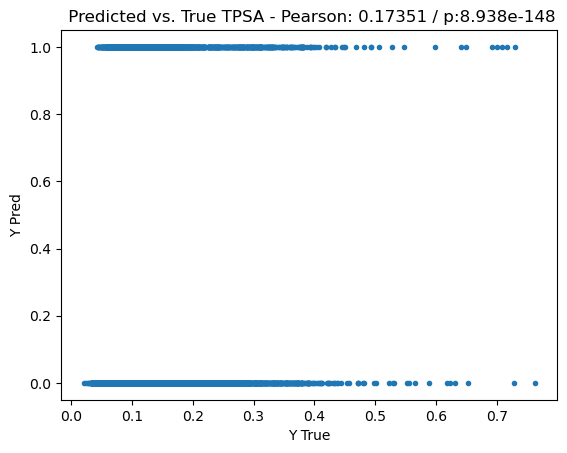

In [186]:
# fig = plt.figure(figsize=(6,6))
plt.plot(y_pred,y_test_np,  '.')
plt.title(f" Predicted vs. True TPSA - Pearson: {pearson_corr:.5f} / p:{pearson_p:.3e}")
plt.xlabel("Y True");
plt.ylabel("Y Pred");
# plt.xlim(1.775, 1.875)
# plt.xlim(1.775, 1.875)

Text(0.5, 0, 'TPSA Value')

Text(0, 0.5, 'Compounds')

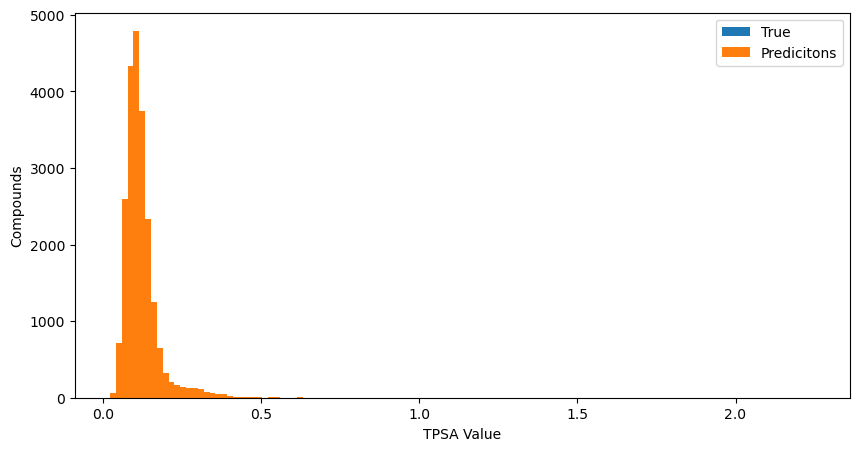

In [187]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 40
# fig, ax = plt.subplots()
 
# the histogram of the data

fig = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(y_test_np, num_bins, density=False, label = 'True', range=[1.5,2.25] )
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(y_pred, num_bins, density=False, label='Predicitons' )
plt.xlabel('TPSA Value')
plt.ylabel('Compounds')
plt.legend()
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

### plot ROC and Precision-Recall Curves

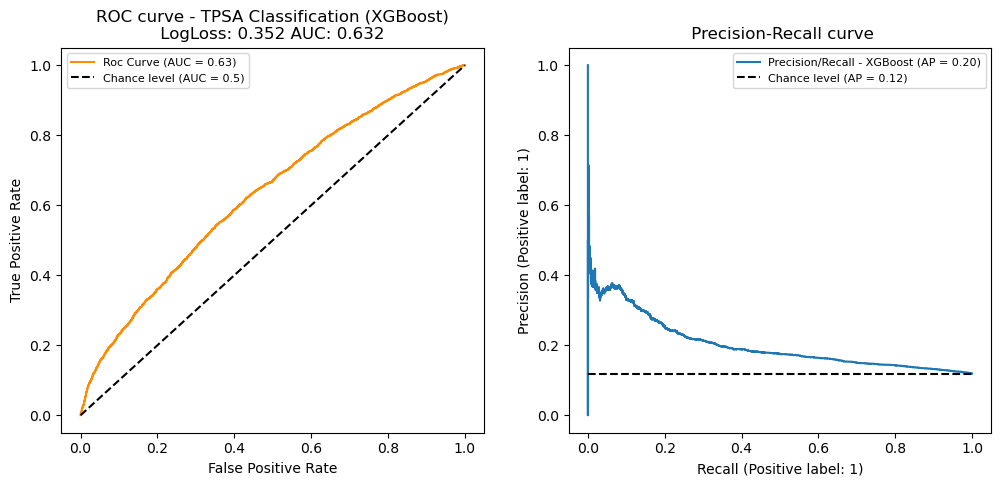

In [191]:
### from sklearn.metrics import RocCurveDisplay
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


roc_display = skm.RocCurveDisplay.from_predictions(
    y_test_np,
    y_pred, 
    name=f"Roc Curve",
    color="darkorange",
    plot_chance_level=True,
    ax = axes[0])

_ = roc_display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve - TPSA Classification (XGBoost)\n LogLoss: {metrics['logloss'] :0.3f} AUC: {metrics['roc_auc']:0.3f} ",
)
_ = roc_display.ax_.legend(fontsize=8);

# prec, recall, _ = skm.precision_recall_curve(y_test, predictions, pos_label=1)
# pr_display = skm.PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display = skm.PrecisionRecallDisplay.from_predictions(
    y_test_np, 
    y_pred, 
    name="Precision/Recall - XGBoost", 
    plot_chance_level=True,
    ax = axes[1])

_ = pr_display.ax_.set_title(" Precision-Recall curve");
_ = pr_display.ax_.legend(fontsize=8);
# plt.show()

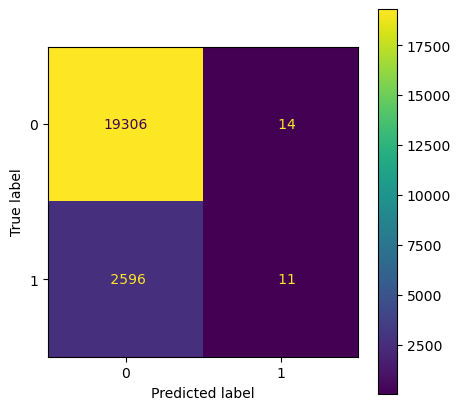

In [190]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
cm_display = skm.ConfusionMatrixDisplay.from_predictions(y_test_np, (y_pred >= 0.5), values_format="5d", ax = axes)

 # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# roc_display.plot(ax=ax1)
# pr_display.plot(ax=ax2)
plt.show()

### Plot Feature Importance 

In [ ]:
# train_score = xgb_reg.score(train_X, train_y)
# val_score = xgb_reg.score(val_X, val_y)
# test_score = xgb_reg.score(test_X, test_y)

In [ ]:
print(f" R2 score - Training   : {train_score:0.6f}")
print(f" R2 score - Validation : {val_score:0.6f}")
print(f" R2 score - Test data  : {test_score:0.6f}")

In [ ]:
# fig = plt.figure(figsize=(20, 20))
# plt.yticks(fontsize = 12)
# ax = fig.add_subplot()
# ax.set_xlim(10,50)
ax = xgb.plot_importance(model_copy, max_num_features= None,  grid = False,  show_values = True, )
for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)

In [ ]:
from graphviz import Source 
xgb.plot_tree(model_copy,num_tress=5)

In [ ]:
# model_copy.attributes()
model_copy.feature_names
model_copy.

In [ ]:
xgb.get_config()

# Optima Study and Trial operations 

In [213]:
db_path = "../cj-datasets/optuna_database.db"
old_db_path = "../cj-datasets/optuna_database_old.db"
storage_url = "sqlite:///../cj-datasets/optuna_database.db"
old_storage_url = "sqlite:///../cj-datasets/optuna_database_old.db"

In [218]:
old_optuna_storage = optuna.storages.RDBStorage(
    url=old_storage_url, 
    heartbeat_interval=60,
    grace_period=120,
    failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
)

/tmp/ipykernel_116824/4240285336.py:5: ExperimentalWarning: RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.
  failed_trial_callback=RetryFailedTrialCallback(max_retry=3),


In [215]:
old_studies = ['multiobjective-study-1',
'multiobjective-study-2',
'multiobjective-study-3']
# 'classification-study-Apr24',
# 'classification-3SampleStudy-Apr24',
# 'classification-study-1'}, ]

In [109]:
with sqlite3.connect(db_path) as conn:
    conn.row_factory = sqlite3.Row
    results = conn.execute("SELECT * FROM studies ;").fetchall()
    db_studies = [dict(r) for r in results]
    db_studies
# study_name = db_studies[-2]['study_name'] 


[{'study_id': 6, 'study_name': 'classification-study-Apr24'},
 {'study_id': 7, 'study_name': 'classification-3SampleStudy-Apr24'},
 {'study_id': 10, 'study_name': 'cls-3_SampleStudy-Aug09'},
 {'study_id': 12, 'study_name': 'test_study_01'},
 {'study_id': 13, 'study_name': 'embd_cls_XGB_base_unbal'},
 {'study_id': 14, 'study_name': 'embd_cls_XGB_snnl_unbal'},
 {'study_id': 15, 'study_name': 'classification-study-Feb24'},
 {'study_id': 16, 'study_name': 'embd_cls_XGB_base_bal_1:1'}]

### Create Study

In [190]:
# study_name = 'embd_cls_XGB_base_bal_1:1'
# optuna
# .delete_study(study_name = study_name, storage=optuna_storage)
# resp = input(f" Delete study {study_name} ?")
# if resp.lower() in ['yes' ,'y']:
#     print(' You responsed yes')
#     try:
#         optuna.delete_study(storage=optuna_storage, study_name=study_name)
#         print("delete successful")
#     except Exception as e:
#         print("delete failed")
# else:
#     print(f" {study_name} will be kept")
# study_name = 'embd_cls_XGB_base_bal_1:1'
# study_name = 'embd_cls_XGB_snnl_bal_1:1'
 
study = optuna.create_study(storage=optuna_storage,
                            study_name=study_name,
                            directions=["maximize","minimize"], 
                            load_if_exists=True)
study.set_metric_names(["roc_auc", "logloss"])

[I 2024-08-12 22:51:25,999] A new study created in RDB with name: embd_cls_XGB_base_bal_1:1
/tmp/ipykernel_292741/1829362024.py:21: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(["roc_auc", "logloss"])


### Move studies

In [223]:
# for st_name in old_studies:
#     optuna.copy_study(
#         from_study_name = st_name,
#         from_storage = optuna_storage,
#         to_study_name = st_name,
#         to_storage = old_optuna_storage,
#     ) 

# for st_name in old_studies:
#     optuna.delete_study(study_name=st_name, storage=optuna_storage)

In [231]:

optuna.copy_study(
    from_study_name = 'classification-study-1',
    from_storage = optuna_storage,
    to_study_name = 'classification-study-Feb24',
    to_storage = optuna_storage,
)

[I 2024-08-12 20:25:41,300] A new study created in RDB with name: classification-study-Feb24


### Delete study

In [188]:
optuna.delete_study(study_name='embd_cls_XGB_base_bal_1:1', storage=optuna_storage)

### Display studies

In [230]:
study_name = 'classification-study-Apr24'
study_name = 'classification-3SampleStudy-Apr24'
study_name = 'classification-study-1'
study  = optuna.load_study(study_name= study_name , storage=optuna_storage)
disp_study_history(study)

 classification-study-1  study history

 Best trials: [1, 12]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-02-04   00:48:09 - 00:54:05    3          *** FAILED ***        
Trial #: 1    2024-02-04   01:15:51 - 01:40:09    1      0.92354        0.20999    
Trial #: 2    2024-02-04   10:36:45 - 12:28:29    1      0.82900        0.34993    
Trial #: 3    2024-02-04   14:50:22 - 15:11:49    1      0.77843        0.32556    
Trial #: 4    2024-02-04   15:11:50 - 16:04:43    1      0.71748        0.36995    
Trial #: 5    2024-02-04   16:04:44 - 16:25:30    1      0.84788        0.29725    
Trial #: 6    2024-02-04   16:25:30 - 16:55:59    1      0.62604        0.36119    
Trial #: 7    2024-02-04   18:06:45 - 18:29:19    3          *** FAILED ***        
Trial #: 8    2024-02-04  

In [189]:
study_name = 'embd_cls_XGB_snnl_unbal'
study_name='embd_cls_XGB_base_bal_1:1'
study  = optuna.load_study(study_name= study_name , storage=optuna_storage)
disp_study_history(study, best_only = True)
study.best_trials[0].params

KeyError: 'Record does not exist.'

In [206]:
study_name = 'embd_cls_XGB_snnl_unbal'
study  = optuna.load_study(study_name= study_name , storage=optuna_storage)
disp_study_history(study, best_only = True)
study.best_trials[0].params

 embd_cls_XGB_snnl_unbal  study history

 Best trials: [42, 66, 71, 73, 82, 85]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 42   2024-08-09   22:40:01 - 22:40:56    1      0.59293        0.34882    
Trial #: 66   2024-08-09   23:05:08 - 23:06:17    1      0.60470        0.35399    
Trial #: 71   2024-08-09   23:11:28 - 23:12:59    1      0.60693        0.35503    
Trial #: 73   2024-08-09   23:14:26 - 23:15:51    1      0.60576        0.35457    
Trial #: 82   2024-08-09   23:24:35 - 23:25:46    1      0.60157        0.35384    
Trial #: 85   2024-08-09   23:27:56 - 23:28:54    1      0.58032        0.30545    
 *** end of trials *** 


{'n_estimators': 50,
 'learning_rate': 0.4186703485177471,
 'min_split_loss': 9.156785271302814,
 'max_depth': 4,
 'min_child_weight': 6.052222966586795,
 'max_delta_step': 5.492408301950244,
 'subsample': 0.4451492735132116,
 'colsample_bylevel': 0.9437439047063692,
 'colsample_bynode': 0.8218063953881926,
 'lamba': 1.0673687248456477e-05,
 'max_leaves': 0}